
# Verkehrszeichenerkennung mit Objektdetektion (YOLOv8, GTSDB, FullIJCNN2013)

Dieses Notebook nutzt **FullIJCNN2013.zip** und/oder eine lokale **gt.csv** und führt Setup, Datenvorbereitung, Training, Validierung, Inferenz und Export aus.


## 1 – Installation der Abhängigkeiten, Imports und Umgebungsprüfung (Python/PyTorch/CUDA)

Diese Zelle erstellt die technische Grundlage für die gesamte Pipeline, indem sie
1) **benötigte Bibliotheken installiert**,  
2) **zentrale Module importiert** (Datenverarbeitung, Bildverarbeitung, Visualisierung, Widgets),  
3) eine **Standard-Plotgröße** konfiguriert und  
4) die **Laufzeitumgebung** (Python/OS/PyTorch/CUDA) ausgibt.

---

- **Reproduzierbarkeit:** Fixierung einer Ultralytics-Version (`ultralytics==8.3.50`) sowie Installation der übrigen Kernabhängigkeiten, um API‑Änderungen und Versionsdrift zu minimieren.
- **Trainings- und Inferenzfähigkeit:** Bereitstellung der Bibliotheken für Objektdetektion (Ultralytics/YOLO), Bild‑I/O (OpenCV, Pillow), Analyse/Plots (NumPy, Pandas, Matplotlib) und Datensatzsplits (scikit‑learn).
- **Deployment‑Vorbereitung:** Installation des ONNX‑Ökosystems (onnx, onnxruntime‑gpu, onnxslim) zur späteren Export‑ und Inferenzpipeline außerhalb von PyTorch.
- **Interaktive Exploration:** Installation und Import von `ipywidgets` zur Erstellung interaktiver Debug‑/Analysewerkzeuge (z. B. Augmentierungs‑Preview, Inferenz‑Viewer).
- **Hardware‑Validierung:** Ausgabe von Python-/Plattform-/PyTorch‑Version und CUDA‑Status als schnelle Verifikations- und Dokumentationsmaßnahme.

---

### Installierte Komponenten
- **Ultralytics/YOLO (`ultralytics==8.3.50`)**: Trainings-, Validierungs-, Inferenz- und Export‑API für YOLO‑Modelle.
- **opencv-python, pillow**: Bildladen, Konvertierung, einfache Bildoperationen.
- **tqdm**: Fortschrittsbalken für Batch‑Verarbeitung.
- **matplotlib**: Visualisierung (Kurven, Histogramme, Debugplots).
- **scikit-learn**: Hilfsfunktionen (z. B. `train_test_split`).
- **pyyaml**: Schreiben/Lesen von YAML‑Konfigurationsdateien (z. B. `data.yaml`).
- **onnx, onnxruntime-gpu, onnxslim**: Exportformat, GPU‑Inferenzruntime und (optionale) Graph‑Vereinfachung.
- **ipywidgets**: Interaktive UI‑Elemente in Jupyter (Slider, Checkboxen, Dropdowns).

---

### Output der Zelle
- Installationsausgaben (abhängig von Notebook‑Umgebung/Caching).
- Konsolen-Ausgabe der Systemdiagnose, typischerweise:
  - Python-Version
  - Plattform/OS
  - PyTorch-Version
  - CUDA‑Verfügbarkeit (True/False)

---

### Theoretischer Hintergrund

#### 1) Abhängigkeitsmanagement in ML‑Workflows
Die Modellleistung und Pipelinefunktionalität sind versionssensitiv (API‑Verhalten, Operatorunterstützung, CUDA‑Kompatibilität). Eine feste Versionierung reduziert Nicht‑Determinismus und erleichtert die Replikation experimenteller Ergebnisse.

#### 2) ONNX‑Ökosystem als Deployment‑Brücke
ONNX repräsentiert Modelle als standardisierte Rechengraphen und ermöglicht Inferenz in unterschiedlichen Runtimes (z. B. ONNX Runtime). Dadurch wird eine Trennung zwischen Trainingsframework (PyTorch) und Deployment‑Runtime möglich.

#### 3) Umgebungsprüfung (CUDA)
Die CUDA‑Verfügbarkeit ist entscheidend für Trainingsdurchsatz, wählbare Batchgrößen und praktikable Eingangsauflösungen. Eine frühe Validierung verhindert spätere Laufzeitfehler (z. B. CPU‑Only‑Training trotz GPU‑Annahme).

In [1]:

# ============================================================
# [Notebook-Setup] Installation der benötigten Pakete
# Hinweis: In Jupyter/Colab können pip-Installationen eine Kernel-Neustart-Anforderung auslösen.
# Falls nach der Installation Import-Fehler auftreten: Runtime/Kernel einmal neu starten.
# ============================================================

!pip install -q ultralytics==8.3.50 opencv-python pillow tqdm matplotlib scikit-learn pyyaml       # Ultralytics YOLO (fest gepinnt für reproduzierbare API), plus Standard-CV/DS-Tools
!pip install onnx onnxruntime-gpu onnxslim                                                         # ONNX-Toolchain für Export + Inferenz

!pip install -q ipywidgets                                                                         # Widgets für interaktive Visualisierung (Slider/Checkboxen etc. im Notebook)
import os, glob, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image, ImageEnhance                                                                # Pillow für Bild-I/O und einfache photometrische Augmentierungen (Brightness/Contrast/Color)
from ipywidgets import interact, fixed, IntSlider, FloatSlider, Dropdown, SelectMultiple, Checkbox # ipywidgets für interaktive Controls (z. B. Augmentierungs-Preview, Inferenz-Viewer)
plt.rcParams['figure.figsize'] = (8, 6)                                                            # Standardgröße für Matplotlib-Figuren (einheitliche Darstellung in allen Plots)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:

# ============================================================
# [System-Check] Laufzeitumgebung verifizieren
# Zweck: Versions- und CUDA-Status ausgeben (wichtig für Trainingsgeschwindigkeit & Batch/imgsz-Wahl)
# ============================================================

import sys, platform, torch
print('Python:', sys.version)
print('Platform:', platform.platform())
print('PyTorch:', torch.__version__, '| CUDA available:', torch.cuda.is_available())


Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Platform: Linux-6.1.0-34-amd64-x86_64-with-glibc2.35
PyTorch: 2.8.0.dev20250319+cu128 | CUDA available: True


## 2 – Datensatzbereitstellung: Entpacken von `FullIJCNN2013.zip` und Download (optional) 

Diese Zelle richtet ein lokales Arbeitsverzeichnis für den Datensatz **FullIJCNN2013** ein und stellt sicher, dass ein vorhandenes ZIP‑Archiv (`FullIJCNN2013.zip`) entpackt wird. Optional kann das ZIP‑Archiv automatisiert von einer angegebenen URL heruntergeladen werden. Die Ausführung ist so gestaltet, dass sowohl **manuelle Bereitstellung** als auch **automatisierter Download** unterstützt werden.

---

- **Standardisierte Ablage:** Definition eines festen Basisverzeichnisses (`gtsdb_fullijcnn2013`) zur konsistenten Datensatzorganisation.
- **Reproduzierbare Datenbereitstellung:** Automatisierbares Setup durch optionalen Downloadmechanismus.
- **Robuste Ausführung:** Fallback‑Logik bei fehlender URL oder fehlendem Archiv, ohne sofortigen Abbruch der Pipeline.

---

### Verarbeitungsschritte

1. **Initialisierung der Verzeichnisstruktur**
   - Erzeugung eines Arbeitsverzeichnisses unter einem absoluten Pfad, um Pfadabhängigkeiten zu reduzieren.
   - Sicherstellen, dass das Verzeichnis existiert (idempotent durch `exist_ok=True`).

2. **Optionaler Download des ZIP‑Archivs**
   - Wenn `ZIP_URL` gesetzt ist und die Datei lokal noch nicht existiert, wird ein Download versucht.
   - Bei Downloadfehlern erfolgt eine kontrollierte Fehlermeldung mit Hinweis auf manuelle Ablage des ZIP‑Archivs.

3. **Entpacken des ZIP‑Archivs**
   - Falls `FullIJCNN2013.zip` im Basisverzeichnis vorhanden ist, wird das Archiv in das gleiche Basisverzeichnis extrahiert.
   - Falls das Archiv nicht vorhanden ist, wird ein Hinweis ausgegeben, dass entweder eine manuelle Bereitstellung erforderlich ist oder der Datensatz bereits entpackt vorliegen kann.

---

### Output der Zelle
- Konsolenausgaben zur Statusdokumentation, typischerweise:
  - Hinweis auf Downloadstart/-abschluss oder Downloadfehler
  - Bestätigung des Entpackpfads nach erfolgreicher Extraktion
  - Hinweistext, falls das ZIP nicht gefunden wurde

---

### Theoretischer Hintergrund

#### 1) Datenbereitstellung als deterministischer Pipeline‑Schritt
In Machine‑Learning‑Workflows ist die **Datenbereitstellung** ein eigenständiger, kritisch zu dokumentierender Schritt. Eine saubere Trennung zwischen
- Datendownload,
- Entpacken/Extraktion,
- späterer Konvertierung/Preprocessing‑Pipeline  
reduziert Fehlerquellen und erhöht die Nachvollziehbarkeit.

---

#### 2) Idempotente Initialisierung
Die Verwendung eines festen Basisverzeichnisses und `exist_ok=True` ermöglicht eine idempotente Ausführung:
- Wiederholtes Ausführen erzeugt keine inkonsistenten Zustände.
- Bereits vorhandene Verzeichnisse blockieren die Pipeline nicht.

---

#### 3) Fehlertoleranz und Fallback‑Strategie
Die Zelle implementiert eine robuste Fallback‑Logik:
- Ist keine Download‑URL gesetzt oder schlägt der Download fehl, kann der Datensatz dennoch durch manuelle Ablage des ZIP‑Archivs bereitgestellt werden.
- Ist das ZIP nicht vorhanden, wird die Ausführung nicht erzwungen abgebrochen; nachfolgende Schritte können dennoch funktionieren, falls der Datensatz bereits entpackt vorliegt.

---

#### 4) Entpacken als notwendige Vorstufe für Annotation‑Parsing
Viele Computer‑Vision‑Datensätze werden als Archive bereitgestellt, um Transfer und Versionierung zu erleichtern. Das Entpacken ist Voraussetzung dafür, dass nachfolgende Schritte (z. B. Zugriff auf `gt.csv`, Bilddateien und Ordnerstruktur) deterministisch auf Dateisystemebene operieren können.


In [3]:

# ============================================================
# [Dataset-Setup] FullIJCNN2013/GTSDB: Ablageordner anlegen, optional downloaden, entpacken
# ============================================================

import os, zipfile, urllib.request

# Basisverzeichnis für den Datensatz (wird relativ zum aktuellen Working Directory angelegt)
# Tipp: In Colab/Notebook ist das typischerweise /content/..., lokal entsprechend das Projektverzeichnis.
BASE_DIR = os.path.abspath('gtsdb_fullijcnn2013')
os.makedirs(BASE_DIR, exist_ok=True)                    # idempotent: kein Fehler, falls Ordner bereits existiert

# ------------------------------------------------------------
# OPTIONAL: Download des ZIP-Archivs
# - Wenn FullIJCNN2013.zip bereits lokal vorliegt, kann ZIP_URL leer bleiben.
# - Wenn ein direkter Download-Link existiert, hier eintragen (z.B. https://.../FullIJCNN2013.zip)
# ------------------------------------------------------------
ZIP_URL = ''                                           # Optional: URL hier eintragen
ZIP_PATH = os.path.join(BASE_DIR, 'FullIJCNN2013.zip') # erwarteter lokaler ZIP-Pfad

# Nur downloaden, wenn eine URL angegeben ist UND die ZIP-Datei noch nicht existiert
if ZIP_URL and not os.path.exists(ZIP_PATH):
    try:
        print('Downloading FullIJCNN2013.zip ...')
        urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)
        print('Done.')
    except Exception as e:
        # Fallback: Download kann scheitern (Auth, Netzwerk, falscher Link, Proxy etc.)
        print('Download failed:', e)
        print('Bitte FullIJCNN2013.zip manuell in', BASE_DIR, 'ablegen.')

# ------------------------------------------------------------
# Entpacken, falls ZIP vorhanden
# - Extrahiert den Inhalt in BASE_DIR
# - Hinweis: Bei wiederholter Ausführung werden Dateien ggf. überschrieben
# ------------------------------------------------------------
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(BASE_DIR)
    print('Extracted to:', BASE_DIR)
else:
    print('Hinweis: ZIP nicht gefunden. Wenn bereits entpackt, geht es weiter.')


Extracted to: /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013


## 3 – Konvertierung des FullIJCNN2013/GTSDB‑Datensatzes in das YOLO‑Format (Train/Val/Test)

Diese Zelle transformiert die Originalannotation des Datensatzes (CSV‑Format mit Bounding‑Box‑Koordinaten) in eine **YOLO‑kompatible Datensatzstruktur**.  
Dabei werden:

- Annotationen aus `gt.csv` eingelesen und pro Bild aggregiert,
- die Bildliste deterministisch in **Train/Validation/Test** aufgeteilt,
- Originalbilder (z. B. `.ppm`) in ein YOLO‑übliches Bildformat (`.jpg`) konvertiert,
- zu jedem Bild eine **YOLO‑Labeldatei (`.txt`)** mit normalisierten Bounding‑Boxes erzeugt,
- die vollständige Ordnerstruktur `yolo_data/images/{split}` und `yolo_data/labels/{split}` aufgebaut.

---

- **Standardisierung:** Überführung in eine weit verbreitete, einfache Objektdetektionsrepräsentation (YOLO‑Format).
- **Trainierbarkeit:** Bereitstellung einer Struktur, die von Ultralytics/YOLO ohne zusätzliche Parser direkt geladen werden kann.
- **Reproduzierbarkeit:** Deterministischer Split durch festen Zufallsseed (`random_state=42`).
- **Kompatibilität:** Einheitliche Bildcodierung (`RGB` → `.jpg`) zur Reduktion von Formatproblemen im Training.

---

### Ergebnis (Output)
- Verzeichnis `yolo_data/` mit folgender Struktur:
  - `yolo_data/images/train/*.jpg`
  - `yolo_data/images/val/*.jpg`
  - `yolo_data/images/test/*.jpg`
  - `yolo_data/labels/train/*.txt`
  - `yolo_data/labels/val/*.txt`
  - `yolo_data/labels/test/*.txt`
- Konsolenausgaben:
  - erkannte Klassen‑IDs,
  - Anzahl der annotierten Bilder,
  - Anzahl Bilder/Labels pro Split (Sanity‑Check).

---

### Methodik

#### 1) Einlesen und Strukturierung der Annotationen
Die CSV‑Annotation (Semikolon‑getrennt) wird in Records überführt. Jede Zeile beschreibt:
- Dateiname,
- Bounding‑Box‑Koordinaten im Pixelraum (`x1, y1, x2, y2`),
- Klassen‑ID (`class_id`).

Anschließend werden Annotationen **pro Bild** gruppiert (Mapping: `image → list(annotations)`), um Mehrfachobjekte pro Bild zu unterstützen.

---

#### 2) Datensatz‑Split (Train/Val/Test)
Die Menge der annotierten Bilder wird in drei disjunkte Mengen zerlegt:
- `train` (80%)
- `val` (10%)
- `test` (10%)

Die Aufteilung erfolgt über `train_test_split` mit festem Seed, um die Vergleichbarkeit zwischen Experimenten zu gewährleisten.

---

#### 3) Bildlokalisierung und Formatkonvertierung
Für jedes referenzierte Bild wird der Dateipfad gesucht (primär `.ppm`, optional Fallback auf `.jpg/.png/.jpeg`).  
Danach erfolgt eine Konvertierung:
- Laden des Originalbildes,
- Konvertierung nach `RGB`,
- Speichern als `.jpg` (Qualitätseinstellung) im Split‑Ordner.

---

#### 4) Transformation der Bounding Boxes ins YOLO‑Format
Die Original‑Boxes liegen als Pixelkoordinaten vor. YOLO erwartet normierte Parameter:

$$x_c = \frac{(x_1 + x_2)/2}{W}, \quad y_c = \frac{(y_1 + y_2)/2}{H}, \quad w_b = \frac{(x_2 - x_1)}{W}, \quad h_b = \frac{(y_2 - y_1)}{H}$$

mit `W, H` als Bildbreite/-höhe.

Pro Bild wird eine Labeldatei erzeugt, die pro Objekt eine Zeile enthält:

`class_id  x_center  y_center  width  height`

(alle Werte für Boxparameter normiert auf `[0,1]`).

---

#### 5) Robustheitsmaßnahmen
- **Fehlende Bilder:** Falls ein Bild nicht gefunden wird, wird es übersprungen (Vermeidung eines Abbruchs der Konvertierung).
- **Ordnererstellung:** Split‑Ordner werden bei Bedarf dynamisch angelegt.
- **Sanity‑Check:** Nach Abschluss werden Anzahl Bild- und Labeldateien pro Split gezählt und ausgegeben.

---

### Theoretischer Hintergrund

#### 1) Warum YOLO‑Format?
Das YOLO‑Format ist eine minimalistische, effiziente Darstellung für Objektdetektion:
- konstante, zeilenbasierte Annotation pro Objekt,
- unabhängige Speicherung von Bild und Label,
- einfache Skalierung auf verschiedene Auflösungen durch Normierung.

Dadurch wird eine robuste Datensatzintegration in gängige Detektionsframeworks erleichtert.

---

#### 2) Bedeutung der Normierung
Die Normierung der Bounding‑Box‑Parameter entkoppelt Annotationen von absoluten Pixelmaßen.  
Das ist vorteilhaft, da:
- Trainingspipelines Bilder häufig reskalieren/letterboxen,
- Modelle auf unterschiedlichen Inputgrößen betrieben werden können,
- Annotationen unabhängig von Originalauflösung konsistent bleiben.

---

#### 3) Warum Train/Val/Test‑Split?
Ein separater Split ermöglicht eine methodisch saubere Bewertung:
- **Train:** Parameterlernen
- **Val:** Modellselektion/Hyperparameterabstimmung
- **Test:** finale, möglichst unverzerrte Endbewertung

Ein deterministischer Split reduziert Varianz in Ergebnisvergleichen und erleichtert Experimentreproduzierbarkeit.

---

#### 4) Relevanz der Bildformatvereinheitlichung (PPM → JPG)
Einheitliche Kodierung reduziert technische Varianz:
- konsistentes Farbmodell (`RGB`),
- bessere Kompatibilität mit Dataloading‑Backends,
- weniger Fehlerquellen durch exotische oder selten unterstützte Formate.

In [4]:

import os, csv, glob, shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import os.path as osp
import glob as gglob

# Basisverzeichnis aus Schritt 2 (ZIP-Entpacken). Dort wird auch yolo_data/ angelegt
ROOT = BASE_DIR

# Datensatzordner heuristisch finden (je nach ZIP-Struktur kann der Ordner unterschiedlich heißen)
possible_dirs = [d for d in glob.glob(os.path.join(ROOT, '*')) if os.path.isdir(d) and 'FullIJCNN' in os.path.basename(d)]
DATA_DIR = possible_dirs[0] if possible_dirs else os.path.join(ROOT, 'FullIJCNN2013')
print('DATA_DIR:', DATA_DIR)

# Ground-Truth CSV (FullIJCNN: Semikolon-getrennt). Fallback: lokale gt.csv im CWD
GT_CSV = os.path.join(DATA_DIR, 'gt.csv')
if not os.path.exists(GT_CSV) and os.path.exists('gt.csv'):
    GT_CSV = 'gt.csv'
print('GT_CSV:', GT_CSV)

# Root für die rekursive Bildsuche
IMG_ROOT = DATA_DIR

# Zielstruktur für Ultralytics/YOLO: images/{split}, labels/{split}
YOLO_DIR = os.path.join(ROOT, 'yolo_data')
for p in [YOLO_DIR, os.path.join(YOLO_DIR, 'images'), os.path.join(YOLO_DIR, 'labels')]:
    os.makedirs(p, exist_ok=True)

# -------------------------------------------------------------------
# gt.csv einlesen: erwartetes Schema = filename; x1; y1; x2; y2; class_id
# -------------------------------------------------------------------
records = []
with open(GT_CSV, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=';')
    for row in reader:
        if len(row) >= 6:
            filename, x1, y1, x2, y2, cid = row
            try:
                rec = {
                    'filename': filename.strip(),
                    'x1': int(x1), 'y1': int(y1), 'x2': int(x2), 'y2': int(y2),
                    'class_id': int(cid)
                }
                records.append(rec)
            except ValueError:
                pass

classes = sorted({r['class_id'] for r in records})
print('Einzigartige Klassen-IDs:', classes)

# Annotationen pro Bild gruppieren (ein Bild kann mehrere Boxen haben)
img_to_ann = defaultdict(list)
for r in records:
    img_to_ann[r['filename']].append(r)

all_images = sorted(img_to_ann.keys())
print('Bilder in gt.csv:', len(all_images))

# Reproduzierbarer Split: 80/10/10
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs,   test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

def find_image_path(filename_ppm):
    # 1) .ppm suchen
    candidates = glob.glob(os.path.join(IMG_ROOT, '**', filename_ppm), recursive=True)
    if candidates:
        return candidates[0]
    # 2) Fallback: stem.jpg/.png
    stem = osp.splitext(filename_ppm)[0]
    for ext in ('.jpg', '.png', '.jpeg'):
        alt = glob.glob(os.path.join(IMG_ROOT, '**', stem + ext), recursive=True)
        if alt:
            return alt[0]
    raise FileNotFoundError(filename_ppm)

def to_yolo(x1, y1, x2, y2, w, h):
    xc = (x1 + x2) / 2.0 / w
    yc = (y1 + y2) / 2.0 / h
    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    return xc, yc, bw, bh

# Schreiben: **PPM→JPG**

def write_yolo(img_name, anns, split):
    src_img = find_image_path(img_name)

    # Einheitliches Bildformat (JPG) für konsistentes Loading in Ultralytics
    dst_img_name = osp.splitext(os.path.basename(src_img))[0] + '.jpg'
    dst_img = os.path.join(YOLO_DIR, 'images', split, dst_img_name)
    os.makedirs(os.path.dirname(dst_img), exist_ok=True)

    # Bild öffnen und als JPG speichern
    with Image.open(src_img) as im:
        im = im.convert('RGB')
        w, h = im.size
        im.save(dst_img, format='JPEG', quality=95)

    # Label-Datei
    dst_lbl = os.path.join(YOLO_DIR, 'labels', split, osp.splitext(dst_img_name)[0] + '.txt')
    os.makedirs(os.path.dirname(dst_lbl), exist_ok=True)

    lines = []
    for a in anns:
        xc, yc, bw, bh = to_yolo(a['x1'], a['y1'], a['x2'], a['y2'], w, h)
        lines.append(f"{a['class_id']} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    with open(dst_lbl, 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

# YOLO-Dataset materialisieren; fehlende Bilder werden übersprungen (Layout kann variieren)
for split, imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
    for img in tqdm(imgs, desc=f'YOLO write {split}'):
        try:
            write_yolo(img, img_to_ann[img], split)
        except FileNotFoundError:
            pass

# Kurzcheck: Anzahl Bilder vs. Labels je Split
import glob
for s in ['train', 'val', 'test']:
    n_imgs = len(glob.glob(os.path.join(YOLO_DIR, 'images', s, '*.jpg')))
    n_lbls = len(glob.glob(os.path.join(YOLO_DIR, 'labels', s, '*.txt')))
    print(f"{s}: {n_imgs} images, {n_lbls} labels")

print('Konvertierung abgeschlossen →', YOLO_DIR)


DATA_DIR: /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/FullIJCNN2013
GT_CSV: /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/FullIJCNN2013/gt.csv
Einzigartige Klassen-IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Bilder in gt.csv: 741


YOLO write test: 100%|██████████| 75/75 [00:00<00:00, 83.89it/s]

train: 592 images, 592 labels
val: 74 images, 74 labels
test: 75 images, 75 labels
Konvertierung abgeschlossen → /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data


### 3.1 – Dataset‑Sanity‑Check: Vollständigkeit von Labels und Verteilung der Bounding‑Box‑Größen

Diese Zelle führt eine **Qualitäts- und Plausibilitätsprüfung** der erzeugten YOLO‑Datenstruktur (`images/` und `labels/`) durch und analysiert die **Größenverteilung der Bounding Boxes** im Trainingssplit. Im Fokus stehen dabei:
1. **Konsistenzprüfung Bild↔Label** je Split (`train`, `val`, `test`)
2. **Statistische Analyse** der relativen Bounding‑Box‑Flächen im Trainingssplit
3. **Identifikation von Extremfällen** (insbesondere sehr kleine Objekte)

---

- **Datenintegrität sicherstellen:** Verhindern, dass Training/Evaluation durch fehlende oder inkonsistente Labeldateien verfälscht wird.
- **Small‑Object‑Charakterisierung:** Quantifizieren, wie häufig sehr kleine Verkehrsschilder auftreten (kritischer Faktor für Detektionsperformance).
- **Parameter- und Strategieableitung:** Ableiten, ob Maßnahmen wie höhere Eingangsauflösung, Mosaic/Copy‑Paste, Multi‑Scale oder spezielle Sampling‑Strategien sinnvoll sind.

---

#### Ausgaben (Output)
- **Split‑Übersicht:** Anzahl der Bilder und Labeldateien pro Split (`train`, `val`, `test`)
- **Warnungen:** Hinweis, falls zu Bildern keine Labeldateien existieren (Beispielausgabe von Dateistämmen)
- **Histogramm:** Verteilung der **relativen Bounding‑Box‑Fläche** (`bw * bh`) im Trainingssplit. Kleine Flächen sind **schwieriger** zu detektieren.
- **Extremfallliste:** Ausgabe der **kleinsten K Bounding Boxes** (nach relativer Fläche) inkl. Bild-/Labelreferenz und Flächenwert

---

#### Methodik

##### 1) Konsistenzprüfung Bild↔Label pro Split
Für jeden Split werden Bilddateien (`*.jpg`) und Labeldateien (`*.txt`) gezählt und über den Dateistamm gematcht.  
Ein Mismatch (Bild ohne Label) wird als Warnsignal ausgegeben, da dies u. a. bedeuten kann:
- fehlerhafte Konvertierung/Export,
- Namensinkonsistenzen nach Formatumwandlung,
- fehlende Annotationen,
- versehentlich ausgelassene Dateien.

---

##### 2) Bounding‑Box‑Flächenanalyse (Trainingssplit)
Aus jeder YOLO‑Labelzeile wird die normierte Bounding‑Box‑Breite `bw` und Höhe `bh` entnommen.  
Die **relative Fläche** wird als

$$A_{\text{rel}} = bw \cdot bh$$

berechnet.

Diese Größe ist dimensionslos (0–1) und erlaubt einen auflösungsunabhängigen Vergleich über Bilder hinweg.

---

##### 3) Identifikation sehr kleiner Targets
Alle Bounding‑Boxes werden gesammelt und nach `A_rel` sortiert.  
Die kleinsten Beispiele werden ausgegeben, um gezielt Extremfälle inspizieren zu können (z. B. für Debugging oder spätere qualitative Analyse).

---

#### Theoretischer Hintergrund

##### 1) Warum ist die Verteilung der Boxflächen relevant?
Die Objektgröße ist ein zentraler Einflussfaktor auf Detektierbarkeit:
- **Kleine Objekte** enthalten nur wenige Pixel → weniger visuelle Information, höhere Empfindlichkeit gegenüber Downsampling.
- **Lokalisierungsfehler** wirken sich bei kleinen Boxen stärker aus (kleine Verschiebungen verursachen relativ große IoU‑Änderungen).
- **Klassenunterscheidung** (z. B. ähnliche Verkehrsschilder) wird schwieriger, wenn feine Details im Pixelraster nicht mehr stabil repräsentiert sind.

Ein Histogramm von `A_rel` zeigt, ob der Datensatz durch viele sehr kleine Instanzen geprägt ist und ob die Lernaufgabe primär ein Small‑Object‑Problem darstellt.

---

##### 2) Warum müssen fehlende Labels vor dem Training erkannt werden?
Fehlende Labeldateien erzeugen typischerweise eine systematische Verzerrung:
- Bilder ohne Labels werden als „negativ“ interpretiert → potenziell falsches Lernen (False Negatives im Training).
- Metriken und Lossverläufe werden schwer interpretierbar, da die Ground‑Truth‑Basis unvollständig ist.
- Validierungs- und Testaussagen verlieren an Aussagekraft, wenn Datenstruktur inkonsistent ist.

---

##### 3) Interpretation typischer Histogrammformen
- **Starker Peak nahe 0:** sehr viele kleine Objekte → Bedarf an Strategien für Small‑Object‑Detektion (z. B. höhere `imgsz`, Mosaic, Copy‑Paste, Multi‑Scale).
- **Breite Verteilung:** starke Skalenvariabilität → Skalenrobustheit (Multi‑Scale, Pyramid‑Features) wird wichtiger.
- **Ausreißer im großen Bereich:** wenige sehr große Objekte → kann Trainingsdynamik dominieren, wenn nicht ausreichend balanciert.

---

##### 4) Nutzen der Extremfallliste (kleinste Boxen)
Die kleinsten Bounding‑Boxes sind häufig die Fälle, die:
- besonders schwer detektierbar sind,
- am stärksten von Augmentierungen/Resizing beeinflusst werden,
- Annotationenfehler am ehesten sichtbar machen (z. B. falsche Boxen bei sehr kleinen Targets).

Eine gezielte Visualisierung dieser Beispiele ist ein effizienter Weg, um Daten- oder Pipelinefehler früh zu identifizieren.  
Mit `TOPK_SMALL` wird die gewünschte Anzahl der kleinsten Objekte angezeigt.


train: 592 images, 592 labels
val: 74 images, 74 labels
test: 75 images, 75 labels


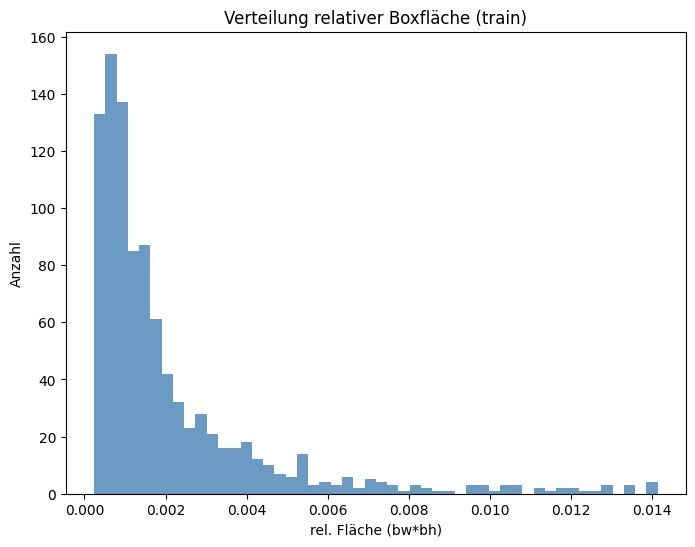

Kleinste 6 Box-Beispiele (rel. Fläche):
00536.jpg -> area_rel=0.000235
00552.jpg -> area_rel=0.000235
00552.jpg -> area_rel=0.000235
00507.jpg -> area_rel=0.000265
00787.jpg -> area_rel=0.000265
00133.jpg -> area_rel=0.000266


In [5]:

import os, glob
from PIL import Image

# Annahme: BASE_DIR, np und plt sind bereits in vorherigen Zellen definiert/importiert
BASE = BASE_DIR
YIM = os.path.join(BASE, 'yolo_data', 'images')
YLB = os.path.join(BASE, 'yolo_data', 'labels')

# ------------------------------------------------------------
# 1) Struktur-/Vollständigkeitscheck: images vs. labels je Split
# ------------------------------------------------------------
splits = ['train','val','test']
stats = []
for s in splits:
    imgs = sorted(glob.glob(os.path.join(YIM, s, '*.jpg')))
    lbls = sorted(glob.glob(os.path.join(YLB, s, '*.txt')))
    print(f"{s}: {len(imgs)} images, {len(lbls)} labels")
    
    # Check: für jedes Bild muss es eine gleichnamige Labeldatei geben (Stem-Vergleich)
    stems_img = {os.path.splitext(os.path.basename(p))[0] for p in imgs}
    stems_lbl = {os.path.splitext(os.path.basename(p))[0] for p in lbls}
    missing_lbl = stems_img - stems_lbl
    if missing_lbl:
        print(f"  WARN: {len(missing_lbl)} Labeldateien fehlen (z.B. {list(missing_lbl)[:3]})")

# ------------------------------------------------------------
# 2) Analyse der Boxgrößen im Train-Split: relative Fläche bw*bh
#    (bw/bh sind YOLO-normalisiert in [0,1])
# ------------------------------------------------------------
train_lbls = sorted(glob.glob(os.path.join(YLB, 'train', '*.txt')))
areas = []
examples = []
for lp in train_lbls:
    stem = os.path.splitext(os.path.basename(lp))[0]
    ip = os.path.join(YIM, 'train', stem + '.jpg')
    if not os.path.exists(ip): 
        continue  # defensiv: Label ohne Bild
        
    with Image.open(ip) as im:
        w, h = im.size  # hier nur für Konsistenz; für area_rel nicht zwingend nötig
        
    with open(lp, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5: 
                continue  # ignoriert fehlerhafte Zeilen
                
            cls, xc, yc, bw, bh = parts
            bw, bh = float(bw), float(bh)
            
            # relative Boxfläche (dimensionslos): Indikator für "kleine Objekte"
            area_rel = bw * bh
            areas.append(area_rel)
            examples.append((ip, lp, area_rel))

# Histogramm der relativen Flächen (Train)
areas = np.array(areas)
plt.hist(areas, bins=50, color='steelblue', alpha=0.8)
plt.title('Verteilung relativer Boxfläche (train)')
plt.xlabel('rel. Fläche (bw*bh)'); plt.ylabel('Anzahl')
plt.show()

# Kleinste K Boxen ausgeben (praktisch für spätere visuelle Inspektion)
TOPK_SMALL = 6
small_sorted = sorted(examples, key=lambda x: x[2])[:TOPK_SMALL]
print(f"Kleinste {TOPK_SMALL} Box-Beispiele (rel. Fläche):")
for ip, lp, a in small_sorted:
    print(f"{os.path.basename(ip)} -> area_rel={a:.6f}")


### 3.2 – Interaktive Augmentierungs‑Vorschau (photometrisch)

**Was macht die Zelle?**
- Zeigt Vorschauen für Helligkeit/Sättigung/Kontrast und Flip.
- „Pseudo‑Mosaic“ (Collage aus 4 Bildern) zur Illustration der Dichtewirkung.

**Stellschrauben**
- Regler für Helligkeit/Sättigung/Kontrast.
- `do_flip`: horizontales Flip.
- `mosaic_preview`: einfache Collage aus 4 zufälligen train‑Bildern.

Diese Zelle implementiert eine **interaktive Vorschau-Pipeline** zur visuellen Exploration typischer Datenaugmentierungen auf Bildern des Trainingssplits. Über Widget‑Regler (Slider/Checkboxen) werden transformationsbasierte Varianten eines ausgewählten Trainingsbildes erzeugt und unmittelbar geplottet. Die Zelle dient ausschließlich der **Visualisierung**; es werden **keine** Trainingsdaten und **keine** Labeldateien dauerhaft verändert oder neu geschrieben.

---

- **Plausibilitätsprüfung von Augmentierungen:** Sicherstellen, dass gewählte Transformationsbereiche realistische Bildvariationen erzeugen, ohne relevante Objektmerkmale (z. B. Piktogramme/Kanten kleiner Verkehrsschilder) zu zerstören.
- **Parametergefühl vor dem Training:** Ableitung sinnvoller Intensitäten für Helligkeit/Sättigung/Kontrast.
- **Frühe Fehlerdiagnose:** Sichtprüfung von Bildformat, Farbraum (RGB) und Lesbarkeit nach Transformationen als Vorstufe zu langen Trainingsläufen.

---

#### Interaktive Bedienelemente (UI)
- **`idx` (Slider):** Auswahl eines Trainingsbildes über den Index.
- **`bright` (Slider):** Skalierung der Bildhelligkeit (photometrische Transformation).
- **`sat` (Slider):** Skalierung der Farbsättigung (photometrische Transformation).
- **`cont` (Slider):** Skalierung des Kontrasts (photometrische Transformation).

---

#### Output der Zelle
- Ein Plot des transformierten Bildes inklusive Titelzeile (Dateiname/Modus).

---

#### Theoretischer Hintergrund

##### 1) Datenaugmentierung als Regularisierung und Robustheitsstrategie
Datenaugmentierung erweitert die empirische Trainingsverteilung durch synthetische Variationen bestehender Beispiele. Dadurch wird das Modell dazu gezwungen, **robuste, generalisierende Merkmale** (Form, Kanten, Symbolstruktur) zu lernen, statt trainingsspezifische Artefakte zu memorieren (Overfitting‑Reduktion). Dieses Prinzip wird häufig als **Domain Randomization** bzw. stochastische Regularisierung im Inputraum betrachtet.

---

##### 2) Photometrische Augmentierungen (Brightness/Saturation/Contrast)
Photometrische Transformationen verändern ausschließlich die **Pixelintensitäten** (nicht die Objektgeometrie). Sie modellieren typische Aufnahmevariationen:
- **Helligkeit:** Schatten, Gegenlicht, Tageszeit, Sensorbelichtung
- **Sättigung:** Weißabgleich, Wetterbedingungen, Kamera-Farbprofil
- **Kontrast:** Nebel, Dunst, Kompressionsartefakte, Low‑light

Für Objektdetektion ist dies insbesondere dann relevant, wenn die Klassenentscheidung auf feinen Textur- und Kantenmustern basiert. Bei **kleinen Objekten** ist der Signalanteil pro Instanz gering; daher ist eine kontrollierte Augmentierungsintensität wichtig, um die Lesbarkeit kleiner Targets nicht zu degradieren.

---

##### Wichtige Abgrenzung
- **Keine Modifikation der Trainingsdaten:** Transformierte Bilder werden nur im Speicher für die Darstellung erzeugt.
- **Keine Label‑Transformation:** Bounding Boxes/Labels werden nicht mittransformiert und nicht angezeigt; die Zelle ist ein Diagnose‑/Explorationswerkzeug, kein Trainingsschritt.

In [6]:

# Erwartet: YIM, Image, ImageEnhance, plt, interact, IntSlider, FloatSlider sind bereits importiert/gesetzt
rnd_train = sorted(glob.glob(os.path.join(YIM, 'train', '*.jpg')))
def augment_preview(idx=0, bright=1.0, sat=1.0, cont=1.0):#, do_flip=False, mosaic_preview=False):
    if not rnd_train:
        print('Keine train-Bilder gefunden.')
        return

    # Index robust clippen (z.B. wenn Slider/Dateiliste nicht synchron ist)
    idx = max(0, min(idx, len(rnd_train)-1))
    ip = rnd_train[idx]

    # Bild laden (RGB) und photometrische Augmentierungen anwenden
    im = Image.open(ip).convert('RGB')
    im = ImageEnhance.Brightness(im).enhance(bright)
    im = ImageEnhance.Color(im).enhance(sat)
    im = ImageEnhance.Contrast(im).enhance(cont)

    plt.imshow(im); plt.axis('off')
    plt.title(f"Augment Preview: {os.path.basename(ip)}")
    plt.show()

# Widget-Binding: Parameterbereiche bewusst moderat gewählt (sinnvoll für schnelle Plausibilitätschecks)
interact(augment_preview,
         idx=IntSlider(min=0, max=max(0, len(rnd_train)-1), value=0),
         bright=FloatSlider(min=0.5, max=1.5, step=0.05, value=1.0),
         sat=FloatSlider(min=0.5, max=1.5, step=0.05, value=1.0),
         cont=FloatSlider(min=0.5, max=1.5, step=0.05, value=1.0));


interactive(children=(IntSlider(value=0, description='idx', max=591), FloatSlider(value=1.0, description='brig…

## 4 – `data.yaml` erstellen (43 Klassen) (Dataset‑Konfiguration für Ultralytics/YOLO)

Diese Zelle generiert eine **YAML‑Konfigurationsdatei** (`data.yaml`), welche den Datensatz für Ultralytics/YOLO **formal beschreibt**.  
Diese Datei ist die **zentrale “Landkarte”** für das Training: Sie sagt YOLO **wo** die Bilder/Labels liegen und **wie viele Klassen** es gibt – inklusive **Klassennamen**.

---

### Was soll damit erreicht werden?
Durch die Erstellung von `data.yaml` wird eine **standardisierte Schnittstelle** bereitgestellt, über die Ultralytics/YOLO

- die **Basisstruktur** des Datensatzes (Root‑Pfad),
- die **Train/Validation/Test‑Splits** (relative Bildpfade),
- die **Anzahl der Klassen** (`nc`) sowie
- die **Zuordnung von Klassen‑IDs zu sprechenden Klassennamen** (`names`)

eindeutig interpretieren kann.

---

### Inhalt der `data.yaml` (konzeptuelle Beschreibung)
Die erzeugte Konfiguration enthält typischerweise folgende Schlüssel:

- **`path`**: Basisverzeichnis des YOLO‑Datensatzes  
  (alle weiteren Pfade werden relativ hierzu aufgelöst)
- **`train` / `val` / `test`**: relative Pfade zu den Bildordnern der jeweiligen Splits  
  (korrespondierende Label‑Ordner werden gemäß YOLO‑Konvention erwartet, z. B. `labels/train`)
- **`nc`**: Anzahl der Objektklassen (hier: **43**)
- **`names`**: Liste der Klassenbezeichnungen in **ID‑Reihenfolge**  
  (Index `i` entspricht Klassen‑ID `i`)

---

### Ergebnis (Output)
- Persistentes Artefakt: **`data.yaml`** im Projektverzeichnis  
- Sichtprüfung: Ausgabe des YAML‑Inhalts im Notebook

---

### Theoretischer Hintergrund

#### 1) Datensatz‑Metadaten als Voraussetzung für reproduzierbares Training
Objektdetektionspipelines trennen häufig **Modell-/Trainingsparameter** von der **Datensatzdefinition**.  
`data.yaml` fungiert als *deklaratives Metadatenobjekt*, das eine konsistente und reproduzierbare Datensatzreferenz ermöglicht (z. B. bei erneuten Trainingsläufen, Validierungen oder Exporten).

#### 2) Konsistenzbedingungen für Klassen‑IDs und Metrikberechnung
YOLO‑Labeldateien kodieren Objekte über eine **numerische Klassen‑ID**. Für fehlerfreies Training und korrekte Metriken gelten zentrale Konsistenzbedingungen:

- `nc` muss der tatsächlichen Anzahl der Klassen entsprechen.
- Klassen‑IDs in Labels müssen im Bereich **0 bis `nc-1`** liegen.
- `names` muss **genau `nc` Einträge** enthalten und die Reihenfolge muss der ID‑Semantik entsprechen.

Verletzungen dieser Bedingungen führen typischerweise zu Fehlinterpretationen (z. B. falsche Klassenbezeichner in Auswertungen) oder zu Laufzeitfehlern.

#### 3) Semantische Interpretation und Ergebnisdiagnostik
Während das Modell intern numerische IDs verwendet, stellt `names` die **semantische Abbildung** bereit. Dies verbessert:

- Interpretierbarkeit von Trainingslogs (z. B. klassenweise mAP),
- Diagnose von Fehlklassifikationen (Confusion Matrix),
- Visualisierung bei Inferenz (Box‑Labeltext statt numerischer ID).

#### 4) YAML als leichtgewichtiges Konfigurationsformat
YAML wird in ML‑Workflows häufig eingesetzt, da es
- menschenlesbar,
- versionskontrollfreundlich (Git),
- einfach erweiterbar (z. B. Pfadwechsel, Ergänzung von Klassen)

ist und damit die Operationalisierung von Experimenten erleichtert.

---

#### Empfohlene Plausibilitätsprüfung (Best Practice)
- **`len(names) == nc`** sicherstellen.
- Labeldateien auf **ID‑Bereich 0…`nc-1`** prüfen.
- Pfadauflösung testen (Existenz von `images/train`, `images/val`, `images/test` relativ zu `path`).

In [7]:

import yaml, os

# YOLOv8/Ultralytics erwartet eine Dataset-Definition als YAML:
# - Pfad zum Dataset-Root
# - relative Pfade zu train/val/test
# - nc = Anzahl Klassen
# - names = Klassenbezeichnungen (Index = class_id)
DATA_YAML = os.path.join(BASE_DIR, 'data.yaml')

# Klassen-Namen in der Reihenfolge der class_id aus gt.csv (0..42).
# Wichtig: Länge von NAMES muss exakt 'nc' entsprechen und zur Label-Konvertierung passen.
NAMES = [
 'Höchstgeschwindigkeit (20 km/h)','Höchstgeschwindigkeit (30 km/h)','Höchstgeschwindigkeit (50 km/h)','Höchstgeschwindigkeit (60 km/h)','Höchstgeschwindigkeit (70 km/h)',
 'Höchstgeschwindigkeit (80 km/h)','Ende der Geschwindigkeitsbeschränkung (80 km/h)','Höchstgeschwindigkeit (100 km/h)','Höchstgeschwindigkeit (120 km/h)','Überholverbot',
 'Überholverbot für Fahrzeuge über 3,5 t','Vorfahrt an der nächsten Kreuzung','Vorfahrtstraße','Vorfahrt gewähren','Stoppschild',
 'Durchfahrt verboten','Verbot für Fahrzeuge über 3,5 t','Einfahrt verboten','Gefahrstelle','Gefährliche Kurve nach links',
 'Gefährliche Kurve nach rechts','Doppelkurve','Unebene Fahrbahn','Glatte Fahrbahn','Fahrbahnverengung rechts',
 'Baustelle','Ampel','Fußgängerüberweg','Achtung Kinder','Radverkehr kreuzt','Schnee- und Eisglätte','Wildwechsel',
 'Ende sämtlicher Geschwindigkeits- und Überholbeschränkungen','Vorgeschriebene Fahrtrichtung: rechts','Vorgeschriebene Fahrtrichtung: links','Vorgeschriebene Fahrtrichtung: geradeaus','Vorgeschriebene Fahrtrichtung: rechts oder geradeaus',
 'Vorgeschriebene Fahrtrichtung: links oder geradeaus','Rechts halten','Links halten','Kreisverkehr','Ende des Überholverbots','Ende des Überholverbots für Fahrzeuge über 3,5 t'
# ALTERNATIVE ENGLISCHE LABELS
# 'Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)','Speed limit (70km/h)',
# 'Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)','Speed limit (120km/h)','No passing',
# 'No passing for vehicles over 3.5 metric tons','Right-of-way at the next intersection','Priority road','Yield','Stop',
# 'No vehicles','Vehicles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
# 'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right','Road work',
# 'Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow','Wild animals crossing',
# 'End of all speed and passing limits','Turn right ahead','Turn left ahead','Ahead only','Go straight or right',
# 'Go straight or left','Keep right','Keep left','Roundabout mandatory','End of no passing','End of no passing by vehicles over 3.5 metric tons'
]

# Ultralytics nutzt 'path' als Root. train/val/test sind relativ zu diesem Pfad.
# Hier: BASE_DIR/yolo_data/images/{train,val,test}
data_cfg = {
    'path': os.path.join(BASE_DIR, 'yolo_data'),
    'train': 'images/train',
    'val':   'images/val',
    'test':  'images/test',
    'nc': 43,                # muss zu len(NAMES) und den Label-IDs passen
    'names': NAMES
}
# YAML schreiben; sort_keys=False lässt die Reihenfolge stabil/lesbar.
with open(DATA_YAML, 'w') as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False)
print(open(DATA_YAML).read())


path: /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data
train: images/train
val: images/val
test: images/test
nc: 43
names:
- "H\xF6chstgeschwindigkeit (20 km/h)"
- "H\xF6chstgeschwindigkeit (30 km/h)"
- "H\xF6chstgeschwindigkeit (50 km/h)"
- "H\xF6chstgeschwindigkeit (60 km/h)"
- "H\xF6chstgeschwindigkeit (70 km/h)"
- "H\xF6chstgeschwindigkeit (80 km/h)"
- "Ende der Geschwindigkeitsbeschr\xE4nkung (80 km/h)"
- "H\xF6chstgeschwindigkeit (100 km/h)"
- "H\xF6chstgeschwindigkeit (120 km/h)"
- "\xDCberholverbot"
- "\xDCberholverbot f\xFCr Fahrzeuge \xFCber 3,5 t"
- "Vorfahrt an der n\xE4chsten Kreuzung"
- "Vorfahrtstra\xDFe"
- "Vorfahrt gew\xE4hren"
- Stoppschild
- Durchfahrt verboten
- "Verbot f\xFCr Fahrzeuge \xFCber 3,5 t"
- Einfahrt verboten
- Gefahrstelle
- "Gef\xE4hrliche Kurve nach links"
- "Gef\xE4hrliche Kurve nach rechts"
- Doppelkurve
- Unebene Fahrbahn
- Glatte Fahrbahn
- Fahrbahnverengung rechts
- Baustelle
- Ampel
- "Fu\xDFg\xE4nger\xFCberweg"
- Achtung Kinder
- Rad

## 5 – YOLOv8‑Training (Fine‑Tuning auf GTSDB mit gezielten Augmentierungen)

Diese Zelle initialisiert ein **vortrainiertes YOLOv8‑Detektionsmodell** (COCO‑Pretraining) und startet anschließend ein **supervised Fine‑Tuning** auf dem zuvor konvertierten GTSDB‑Datensatz (über `data.yaml`). Der Trainingslauf wird unter einem definierten Projekt-/Run‑Pfad protokolliert und mit einer **Augmentierungs- und Trainingsstrategie** konfiguriert, die insbesondere auf **kleine Objekte** (kleine Verkehrsschilder im Bild) abzielt.

---

- **Transfer Learning / Fine‑Tuning:** Nutzung vortrainierter Gewichte zur schnelleren Konvergenz und besseren Generalisierung bei begrenzter Datensatzgröße.
- **Verbesserung der Small‑Object‑Detektion:** Erhöhung der effektiven Pixelauflösung und Erzeugung hoher Objektdichte in Trainingssamples durch geeignete Augmentierungen (z. B. Mosaic, Copy‑Paste, Multi‑Scale).
- **Reproduzierbare Protokollierung:** Einheitliche Ablage von Metriken, Checkpoints und Artefakten eines Runs in einer Run‑Struktur (z. B. `runs/...`).  

---

### Zentrale Konfiguration
**Trainingsregime**
- **Epochenzahl:** 50 (kann variiert werden)  
- **Batchgröße:** 16 (je höher desto schneller das Training, allerdings kann es zum OOM (Out-of-Memory) Fehler kommen)  
- **Eingangsauflösung:** 1024 px (höhere Detailtreue für kleine Schilder, Rechenaufwand steigt)  
- **Optimizer:** AdamW (Gewichtsentkopplung von Weight Decay; stabil bei Fine‑Tuning)  

**Augmentierungsstrategie (mit Fokus auf kleine Objekte)**
- **Photometrische Augmentierungen (HSV‑Jitter):** Variation von Farbton/Sättigung/Helligkeit zur Robustheit gegenüber Beleuchtungs- und Kameraschwankungen.
- **Geometrie (moderate Translation/Scale, keine Rotation/Shear/Perspective):** Reduktion unrealistischer Verzerrungen, die kleine, detailarme Targets leicht unkenntlich machen können.  
- **Horizontaler Flip:** Erhöhung der Varianz bei Szenenorientierung, ohne vertikale Inversionen zu erzeugen (typisch unplausibel für Straßenszenen).  
- **Mosaic:** Erhöhung der Objektanzahl pro Trainingsbild und Verteilung über viele Skalen/Positionen; vorteilhaft für kleine Targets.
- **MixUp (gering):** leichte lineare Bildmischung zur Regularisierung; zu hohe Anteile können feine Texturen kleiner Schilder verwischen.  
- **Copy‑Paste:** Kopieren/Einfügen von Objekten zur künstlichen Erhöhung der Häufigkeit kleiner Instanzen und zur Verringerung von Klassen-/Skalenimbalance.
- **Close Mosaic:** Deaktivierung von Mosaic in den letzten Epochen zur Stabilisierung/Schärfung des finalen Fine‑Tunings (Reduktion starker Kompositionsstörungen gegen Trainingsende).  

**Datenpipeline/Performance**
- **Multi‑Scale Training:** Variation der Input‑Skala zwischen Iterationen zur Skalenrobustheit.  
- **Cache:** Zwischenspeicherung der Bilder im RAM/auf schnellem Storage zur Reduktion von I/O‑Bottlenecks.  

---

### Ergebnisartefakte (Output)
Ein erfolgreicher Run erzeugt typischerweise:
- **Checkpoints:** `best.pt` / `last.pt` (Gewichte)  
- **Metrikprotokolle:** u. a. `results.png` (Loss, Precision/Recall, mAP‑Verläufe)  
- **Visualisierungen:** Trainingskurven, Beispielpredictions, Confusion‑Matrix (je nach Konfiguration)  
- **Run‑Ordnerstruktur:** eindeutige Ablage unter `.../runs/<run_name>/...`  

---

## Theoretischer Hintergrund

### 1) Transfer Learning und Fine‑Tuning
YOLO‑Modelle profitieren stark von **vortrainierten Backbones**, die generische visuelle Merkmale (Kanten, Texturen, Formen) bereits lernen. Beim Fine‑Tuning werden diese Merkmale auf die Zieldomäne (Verkehrsschilder) spezialisiert, wodurch bei begrenzter Datenmenge häufig eine bessere Generalisierung erreicht wird als beim Training „from scratch“.

### 2) Small‑Object‑Problem in der Objektdetektion
Kleine Objekte besitzen wenige Pixel und werden durch Downsampling in CNN‑Backbones leicht informationsarm. Maßnahmen wie **höhere Eingangsauflösung** und **Augmentierungen, die Objektpräsenz und Skalenvarianz erhöhen** (Mosaic, Copy‑Paste, Multi‑Scale), wirken dem entgegen, indem sie:
- den effektiven Informationsgehalt pro Objekt erhöhen,
- die Häufigkeit kleiner Instanzen im Training steigern,
- Skalen- und Positionsinvarianzen fördern.

### 3) Augmentation als Regularisierung (“Domain Randomization”)
Photometrische und kompositorische Augmentierungen simulieren reale Variationen (Licht, Kamera, Szeneaufbau) und erzwingen robuste Entscheidungsmerkmale statt datenbankspezifischer Artefakte. Dies reduziert Overfitting und erhöht die Robustheit in unbekannten Bedingungen.

### 4) Optimierung und Stabilität (AdamW)
AdamW entkoppelt Weight Decay von der adaptiven Momentenschätzung und kann bei Fine‑Tuning‑Szenarien stabilere Konvergenz liefern. In Kombination mit augmentierten, stark variierenden Batches wird häufig ein guter Bias‑Variance‑Trade‑off erreicht.

### 5) Design‑Rationale: `imgsz=1024`, `mosaic`, `copy_paste`, `close_mosaic`

#### `imgsz=1024` (höhere Eingangsauflösung)
- **Motivation (Small‑Object‑Detektion):** Kleine Objekte belegen nur wenige Pixel. Eine größere Trainings‑Eingangsauflösung erhöht die Anzahl der Pixel pro Objekt und reduziert Informationsverlust durch Downsampling/Resizing, wodurch Merkmale (Kanten, Symbole, feine Texturen) besser repräsentiert werden können.
- **Technischer Hintergrund:** Während des Trainings müssen Bilder für Mini‑Batches auf eine einheitliche Tensorform gebracht werden; `imgsz` definiert diese Zielgröße. Die Vorverarbeitung erfolgt typischerweise mittels „Letterboxing“ zur Aspektverhältnis‑Erhaltung, sodass Geometrieverzerrungen minimiert werden.
- **Trade‑off:** Rechenaufwand und Speicherbedarf steigen überproportional (≈ quadratisch mit der Kantenlänge). Entsprechend wird `imgsz=1024` häufig mit reduzierter Batchgröße kombiniert.

#### `mosaic` (Kompositions‑Augmentierung durch Bild‑Stitching)
- **Motivation:** Mosaic kombiniert mehrere Trainingsbilder zu einem Sample und erhöht damit **Objektdichte**, **Kontextvariation** und **Skalen-/Positionsdiversität** pro Iteration. Dies ist besonders vorteilhaft für kleine Objekte, da deren Auftretenshäufigkeit und Varianz im Training effektiv steigen.
- **Theorie:** Mosaic ist eine „Mix‑Augmentation“, die die Trainingsverteilung gezielt verbreitert (Domain Randomization) und dadurch Overfitting reduziert. Die Implementierung in YOLO‑Pipelines transformiert Bild *und* Annotationen konsistent, sodass Bounding Boxes nach dem Stitching korrekt bleiben.
- **Erwarteter Effekt:** Verbesserte Generalisierung und stabilere Detektion bei variierenden Objektgrößen und Bildkontexten, insbesondere bei **dichten Szenen** bzw. vielen kleinen Instanzen.

#### `copy_paste` (Instanzbasiertes Duplizieren/Einfügen)
- **Motivation:** Copy‑Paste erhöht die Anzahl von **positiven Instanzen** im Training ohne zusätzliche Datenerhebung und kann **Klassen‑ und Skalenimbalance** reduzieren. Für kleine Objekte lassen sich gezielt zusätzliche, realistisch platzierte Instanzen generieren, wodurch der Lerndruck auf seltene/kleine Targets steigt.
- **Theorie:** Instanzbasierte Augmentierung erweitert die empirische Verteilung der Objekt‑Instanzen (insbesondere Häufigkeit und Kontext), ohne die globale Bildstatistik so stark zu verändern wie Pixel‑Mixing‑Methoden. In YOLO‑Augmentierungspipelines ist Copy‑Paste als Bestandteil der zusammengesetzten Transformationskette vorgesehen.
- **Praktischer Nutzen bei Small Objects:** Häufigere Gradientenupdates zu kleinen Boxen verbessern Lokalisierungslernen (Box‑Regression) und Klassifikationslernen in Regionen mit geringen Pixelinformationen.

#### `close_mosaic=10` (Deaktivierung von Mosaic in den letzten Epochen)
- **Motivation:** Starke Kompositions‑Augmentierungen (z. B. Mosaic) erzeugen Trainingssamples, deren Statistik von der Zielverteilung (Val/Test) abweichen kann. Das Abschalten in den letzten Epochen reduziert diese „Augmentierungs‑Domain‑Shift“ und unterstützt ein **sauberes Fine‑Tuning** auf natürlicheren Bildverteilungen.
- **Theorie:** Gegen Trainingsende wird häufig eine **Stabilisierungsphase** eingesetzt, um die Loss‑Landschaft unter weniger stochastischer Datenmanipulation zu optimieren. Dadurch können Validierungsmetriken (mAP/Recall) stabiler werden, während weiterhin von den Regularisierungseffekten früherer Epochen profitiert wird.
- **Operationalisierung:** `close_mosaic=10` bedeutet, dass Mosaic‑Augmentierung in den letzten 10 Epochen deaktiviert wird. Entsprechende Default‑Setups werden in Ultralytics‑Konfigurationen explizit diskutiert und umgesetzt.

#### Zusammenfassung (kombinierter Effekt)
- `imgsz=1024` erhöht die **Signalqualität** kleiner Objekte durch mehr Pixelinformation.
- `mosaic` erhöht **Objektdichte** und **Skalenvarianz** pro Batch und stärkt Small‑Object‑Lernen.  
- `copy_paste` erhöht **Instanzhäufigkeit** und adressiert **Imbalance** (besonders relevant bei kleinen/seltenen Klassen).
- `close_mosaic` reduziert gegen Ende den **Augmentierungs‑Domain‑Shift** und stabilisiert das finale Fine‑Tuning.


In [8]:

# Ultralytics-API: lädt ein vortrainiertes YOLOv8-Checkpoint-File als Startpunkt fürs Fine-Tuning.
# Hinweis: Der Run-Name (gtsdb_yolov8n_aug) ist nur ein Output-Label und muss nicht zur Backbone-Größe passen.
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

# Output-Ordner/Artefakte dieses Trainingslaufs (Ultralytics schreibt u.a. results.csv, weights/, plots/, ...)
run_dir = os.path.join(BASE_DIR, 'runs', 'gtsdb_yolov8n_aug')
csv_path = os.path.join(run_dir, 'results.csv')

if os.path.exists(csv_path):
    os.remove(csv_path)

# Training starten (Ultralytics erstellt unter project/name automatisch die Run-Struktur).
# Voraussetzung: DATA_YAML zeigt auf ein korrektes YOLO-Dataset (images/..., labels/..., nc, names).
results = model.train(
    data=DATA_YAML,
    epochs=50,
    # Auflösung/Batch sind die größten Hebel für Speicherbedarf und Kleinstobjekt-Qualität:
    imgsz=1024,              # von 640 -> 1024: mehr Pixel/Details für kleine Schilder, dafür langsamer/mehr VRAM
    batch=16,                # Batchgröße; bei OOM reduzieren (stark hardwareabhängig)
    optimizer='adamw',       # stabil für Fine-Tuning; Alternative wäre SGD/Adam je nach Setup
    project=os.path.join(BASE_DIR, 'runs'),
    name='gtsdb_yolov8n_aug',
    exist_ok=True,           # True: Ordner wird wiederverwendet statt Fehler bei bereits existierendem Run

    # --- Augmentierungen gezielt für kleine Objekte ---
    augment=True,            # Augmentierungen aktiv (Safety-Switch)

    # Farb-Jitter (hilft gegen unterschiedliche Belichtung/Wetter)
    hsv_h=0.015,             # Hue-Variation
    hsv_s=0.7,               # Sättigung
    hsv_v=0.4,               # Helligkeit/Value

    # Geometrische Augmentierungen: bei kleinen Objekten vorsichtig dosieren (Detailverlust/Artefakte)
    degrees=0.0,             # Rotation aus: Schilderorientierung ist meist semantisch relevant
    translate=0.10,          # leichte Verschiebung
    scale=0.50,              # Skalierung (wirkt wie Multi-Scale), kann kleine Targets stärken/schwächen
    shear=0.0,               # Scherung aus: verzerrt Texturen/Kanten stark
    perspective=0.0,         # Perspektive aus: vermeidet Artefakte bei sehr kleinen Objekten

    # Spiegelungen: horizontal oft ok (Fahrtrichtungsszenen), vertikal i.d.R. unnatürlich
    flipud=0.0,              # kein Flip nach oben/unten (unnatürlich für Straßenszenen)
    fliplr=0.5,              # horizontales Flip (üblich, robust gegenüber Richtung)

    # Kontext-/Kompositions-Augmentierungen: erhöhen “Objektdichte” und Variabilität
    mosaic=1.0,              # 4-Bild-Mix: bringt häufig viele kleine Objekte ins Bild
    mixup=0.05,              # nur leicht: zu viel kann feine Klassenmerkmale verwässern
    copy_paste=0.30,         # dupliziert Objekte in neue Kontexte; für kleine Targets oft sehr effektiv

    # Trainingsstrategie: am Ende Mosaic deaktivieren, um auf “natürlichen” Bildern zu finetunen
    close_mosaic=10,         # letzte 10 Epochen ohne Mosaic -> stabileres Final-Tuning
    multi_scale=True,        # randomisierte Skalen pro Batch -> robust gegen Größen-/Distanzvariation
    cache=True               # cached Bilder in RAM/Disk -> schnellere I/O; sinnvoll bei ausreichend RAM
)


Ultralytics 8.3.50 🚀 Python-3.11.11 torch-2.8.0.dev20250319+cu128 CUDA:0 (Quadro RTX 8000, 48593MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=True, device=None, workers=8, project=/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs, name=gtsdb_yolov8n_aug, exist_ok=True, pretrained=True, optimizer=adamw, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/labels/train.cache... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.0GB RAM): 100%|██████████| 592/592 [00:00<00:00, 930.56it/s]
val: Scanning /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/labels/val.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 74/74 [00:00<00:00, 684.47it/s]


Plotting labels to /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      17.9G      1.434      5.526      1.031         44       1184: 100%|██████████| 37/37 [00:10<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         74        117          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      16.2G      1.412      3.279      1.056         47        640: 100%|██████████| 37/37 [00:06<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         74        117          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      17.3G      1.264       2.87      1.036         53       1440: 100%|██████████| 37/37 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.58it/s]

                   all         74        117        0.2      0.392       0.16      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      14.2G        1.3      2.587      1.054         54        576: 100%|██████████| 37/37 [00:07<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         74        117      0.301      0.331      0.136     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.4G      1.166      2.311     0.9933         62        800: 100%|██████████| 37/37 [00:06<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


                   all         74        117      0.296      0.474       0.29       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      14.7G      1.115      2.181     0.9803         42        736: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

                   all         74        117      0.617      0.341      0.269      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      14.3G      1.067      2.026     0.9657         32        704: 100%|██████████| 37/37 [00:07<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.87it/s]

                   all         74        117      0.421      0.475       0.35      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      14.7G     0.9848      2.045      0.955         44       1312: 100%|██████████| 37/37 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]

                   all         74        117      0.528      0.331      0.347      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.9G      1.038      2.065     0.9646         33        576: 100%|██████████| 37/37 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


                   all         74        117      0.361       0.48       0.37      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.2G     0.9814      1.967     0.9495         41        800: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


                   all         74        117      0.516      0.536      0.382      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      19.3G     0.9904       1.88     0.9516         32       1216: 100%|██████████| 37/37 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         74        117      0.613      0.396      0.379      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        15G     0.9779      1.764      0.937         47       1216: 100%|██████████| 37/37 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]


                   all         74        117      0.521      0.549      0.472      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      16.9G     0.9288      1.653     0.9026         41        704: 100%|██████████| 37/37 [00:06<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]


                   all         74        117      0.555      0.525      0.394      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      14.1G     0.8859      1.585     0.9116         50       1344: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

                   all         74        117      0.536       0.56      0.481      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        14G       0.87      1.531     0.9078         37        800: 100%|██████████| 37/37 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]

                   all         74        117      0.488      0.566      0.482      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      15.8G     0.8645      1.533     0.8896         35        704: 100%|██████████| 37/37 [00:07<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]

                   all         74        117      0.495      0.649       0.55      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      21.6G      0.842      1.511     0.9244         34        640: 100%|██████████| 37/37 [00:09<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]

                   all         74        117      0.439      0.577      0.462      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      17.6G     0.8419      1.488     0.9037         34        896: 100%|██████████| 37/37 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]

                   all         74        117      0.421      0.608      0.479        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      14.3G     0.8521      1.433     0.8964         45        768: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

                   all         74        117      0.426      0.491      0.468      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      15.4G     0.8481       1.41     0.8795         39       1440: 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.55it/s]


                   all         74        117      0.647      0.413       0.52      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      14.7G      0.804      1.347     0.9014         55       1024: 100%|██████████| 37/37 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


                   all         74        117      0.492      0.658      0.584      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.8G     0.7937      1.312     0.8745         46        544: 100%|██████████| 37/37 [00:07<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

                   all         74        117      0.437      0.719      0.572      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      13.3G     0.7904      1.284     0.8941         29       1280: 100%|██████████| 37/37 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.04it/s]

                   all         74        117      0.438      0.641      0.588      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        15G     0.8048      1.296     0.8636         45       1120: 100%|██████████| 37/37 [00:07<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]

                   all         74        117      0.476      0.654      0.601        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      16.9G     0.8352      1.312     0.8993         41        576: 100%|██████████| 37/37 [00:07<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


                   all         74        117       0.55      0.602      0.597      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      14.8G      0.769      1.262     0.8828         38       1280: 100%|██████████| 37/37 [00:08<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]

                   all         74        117      0.417      0.656      0.522      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      14.8G     0.7672      1.261     0.8701         56        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]

                   all         74        117      0.684      0.491      0.619      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.3G     0.7201      1.192     0.8697         36        864: 100%|██████████| 37/37 [00:08<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

                   all         74        117      0.444      0.706      0.581      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      16.3G     0.7171       1.16     0.8673         53       1312: 100%|██████████| 37/37 [00:08<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

                   all         74        117      0.449      0.656      0.545      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      14.3G     0.7302      1.103     0.8533         27        864: 100%|██████████| 37/37 [00:07<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]

                   all         74        117      0.526      0.647      0.603        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      14.7G     0.7258      1.123     0.8744         55       1248: 100%|██████████| 37/37 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]

                   all         74        117      0.683      0.576      0.648      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      16.3G      0.721      1.114     0.8587         46        544: 100%|██████████| 37/37 [00:07<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]

                   all         74        117      0.512      0.659      0.578      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      17.2G     0.7276       1.09     0.8478         52       1312: 100%|██████████| 37/37 [00:07<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

                   all         74        117      0.482      0.604      0.597      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      20.3G     0.7328      1.106     0.8507         43        992: 100%|██████████| 37/37 [00:07<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

                   all         74        117      0.481      0.632      0.532      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.7G     0.6941      1.069     0.8752         47       1344: 100%|██████████| 37/37 [00:08<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

                   all         74        117      0.775        0.5      0.675      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      19.3G      0.684      1.033      0.861         50        768: 100%|██████████| 37/37 [00:08<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         74        117      0.574      0.585      0.647      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        20G     0.6565     0.9805     0.8523         50       1472: 100%|██████████| 37/37 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.76it/s]

                   all         74        117      0.612      0.564      0.642      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.9G     0.6975      1.019     0.8553         53       1408: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

                   all         74        117      0.615       0.54      0.643      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      15.1G     0.6526     0.9599     0.8609         46        672: 100%|██████████| 37/37 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]

                   all         74        117      0.549      0.592      0.591       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      18.2G     0.6622     0.9804     0.8439         43       1376: 100%|██████████| 37/37 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

                   all         74        117      0.551      0.623      0.591      0.498


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      16.3G     0.6861      1.216      0.864         20        960: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         74        117      0.522      0.663      0.624      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      16.2G     0.7214      1.188     0.8767         26        512: 100%|██████████| 37/37 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


                   all         74        117      0.491      0.654       0.64      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      14.1G     0.6922      1.168     0.8512         23        928: 100%|██████████| 37/37 [00:07<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         74        117      0.656       0.53        0.7      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      14.2G      0.672      1.143     0.8595         29       1024: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

                   all         74        117      0.455      0.659      0.655       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      14.1G     0.6591       1.07     0.8516         25       1408: 100%|██████████| 37/37 [00:08<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

                   all         74        117      0.629      0.557      0.673      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.1G     0.6602      1.077     0.8388         24        544: 100%|██████████| 37/37 [00:07<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

                   all         74        117      0.637      0.534      0.647      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      18.5G     0.6406      1.044      0.845         22        960: 100%|██████████| 37/37 [00:08<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]

                   all         74        117      0.507      0.644      0.685      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      16.2G     0.6505      1.038     0.8372         24       1024: 100%|██████████| 37/37 [00:07<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

                   all         74        117      0.514      0.674      0.715      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      16.4G     0.6254     0.9971     0.8336         22        576: 100%|██████████| 37/37 [00:07<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all         74        117      0.704      0.531      0.703      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.4G     0.6217     0.9862     0.8357         25       1280: 100%|██████████| 37/37 [00:07<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         74        117      0.611      0.564      0.705       0.61



50 epochs completed in 0.125 hours.
Optimizer stripped from /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/last.pt, 6.3MB
Optimizer stripped from /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.pt, 6.3MB

Validating /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.11.11 torch-2.8.0.dev20250319+cu128 CUDA:0 (Quadro RTX 8000, 48593MiB)
Model summary (fused): 168 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


                   all         74        117      0.705      0.529      0.712        0.6
Höchstgeschwindigkeit (30 km/h)          7          7      0.444      0.714       0.83      0.712
Höchstgeschwindigkeit (50 km/h)          7         10      0.669      0.606      0.686      0.567
Höchstgeschwindigkeit (60 km/h)          3          3      0.312      0.333      0.292      0.256
Höchstgeschwindigkeit (70 km/h)          7         11       0.65      0.173      0.535      0.464
Höchstgeschwindigkeit (80 km/h)          2          3     0.0297     0.0297      0.597      0.504
Ende der Geschwindigkeitsbeschränkung (80 km/h)          1          2      0.697          1      0.995      0.846
Höchstgeschwindigkeit (120 km/h)          4          7          1      0.823      0.937      0.718
         Überholverbot          5          5      0.562        0.4      0.656      0.593
Überholverbot für Fahrzeuge über 3,5 t          8         13      0.803      0.923      0.952      0.794
Vorfahrt an de

### 5.1 – Auswertung des Trainingsverlaufs anhand `results.png` (Learning Curves: loss, mAP, Precision/Recall)

Diese Zelle dient der **post-hoc Analyse** eines YOLO‑Trainingslaufs, indem die während des Trainings protokollierten Kennzahlen aus der Datei **`results.png`** eingelesen und als **Lernkurven über die Epochen** visualisiert werden. Die Darstellung ermöglicht eine komprimierte, zeitliche Sicht auf Optimierungsfortschritt, Stabilität und mögliche Generalisierungsprobleme.

---

- **Konvergenzdiagnostik:** Beurteilung, ob die Optimierung (Loss‑Komponenten) über die Epochen systematisch sinkt und stabilisiert.
- **Leistungsmonitoring:** Beobachtung von Detektionsmetriken (z. B. Precision, Recall, mAP) über die Zeit, um Verbesserungen oder Plateaus zu identifizieren.
- **Fehlerbilder erkennen:** Indikatoren für Overfitting/Underfitting werden sichtbar, z. B. durch divergierende Trends (steigende Validierungs‑Loss bzw. stagnierende mAP trotz sinkender Trainings‑Loss).
- **Run‑Vergleich:** Standardisierte Kurven erlauben den Vergleich mehrerer Konfigurationen (z. B. andere Augmentierungen, andere `imgsz`, anderes Modell).  

---

#### Output der Zelle
- **Line‑Plot(s)** der in `results.png` enthaltenen Kenngrößen über der Epoche (x‑Achse: Epochenindex; y‑Achse: jeweilige Kennzahl).

---

#### Theoretischer Hintergrund: Warum sind Lernkurven essenziell?

##### 1) Lernkurven als empirische Optimierungsdiagnose
Beim Training wird ein parametrisiertes Modell durch Minimierung einer Zielfunktion iterativ angepasst. Lernkurven zeigen, **ob** und **wie** das Optimierungsverfahren Fortschritt erzielt (z. B. monotone oder stochastische Abnahme der Loss‑Größen) und ob ein Plateau erreicht wird.

##### 2) Interpretation typischer YOLO‑Loss‑Komponenten
Für YOLO‑Detektion setzt sich die Gesamt‑Loss typischerweise aus mehreren Anteilen zusammen, u. a.:
- **Box‑Loss:** Fehler der Bounding‑Box‑Regression (Lokalisierung).  
- **Cls‑Loss:** Fehler der Klassifikation (Klassenwahrscheinlichkeiten).  
- **DFL‑Loss:** Distribution Focal Loss als Bestandteil der Box‑Regression (feinere Lokalisierung über diskrete Verteilungen).

Sinkende Loss‑Kurven deuten auf verbessertes Fitten der Trainingsdaten hin, sind jedoch **nicht hinreichend** für gute Generalisierung.

##### 3) Metriken (Precision/Recall/mAP) als Generalisierungsindikatoren
Für Objektdetektion werden Leistungsmetriken eingesetzt, die die Detektionsqualität auf Validierungs-/Testdaten zusammenfassen:
- **Precision:** Anteil korrekter positiver Vorhersagen (Kontrolle von False Positives).  
- **Recall:** Anteil gefundener Ground‑Truth‑Objekte (Kontrolle von False Negatives).  
- **mAP:** Zusammenfassende Präzisionskennzahl über Klassen und IoU‑Schwellen.

Metrikkurven sind besonders relevant, da sie die Güte **auf nicht gesehenen Daten** abbilden und damit das primäre Ziel (Generalisierung) näher repräsentieren als Trainings‑Loss.

##### 4) Overfitting/Underfitting über Kurvenverläufe
- **Underfitting:** Loss bleibt hoch und Metriken steigen kaum → Modellkapazität/Hyperparameter/Datenpipeline unzureichend.
- **Overfitting:** Trainings‑Loss sinkt weiter, während Validierungsmetriken stagnieren oder schlechter werden → Modell beginnt trainingsspezifische Muster zu memorieren.

Lernkurven liefern damit eine empirische Grundlage für Maßnahmen wie Anpassung von Augmentierung, Regularisierung, Trainingsdauer oder Modellgröße.


In [9]:

import matplotlib.image as mpimg

import os
from IPython.display import HTML, display

# Pfad an dem Run anpassen:
# Erwartet Ultralytics-Standardstruktur: <project>/<name>/results.png
run_dir = os.path.join(BASE_DIR, 'runs', 'gtsdb_yolov8n_aug')
png_path = os.path.join(run_dir, 'results.png')

# Guard: ohne PNG gibt es nichts zu plotten (z.B. wenn Training nie gestartet/abgebrochen wurde).
if not os.path.exists(png_path):
    print("results.png nicht gefunden:", png_path)
else:
    rel = os.path.relpath(png_path, os.getcwd())
    display(HTML(f"<img src='{rel}' style='width:100%; height:auto; display:block;'>"))


## 6 – Validierung und Testauswertung/Metriken (`model.val` auf `val` und `test`)

Diese Zelle führt eine **modellinterne Evaluation** des trainierten YOLO‑Detektors auf zwei getrennten Datenpartitionen durch:
- **Validation‑Split (`split='val'`)** zur laufenden Qualitätskontrolle und Hyperparameter‑Einordnung.
- **Test‑Split (`split='test'`)** zur abschließenden, möglichst unverzerrten Leistungsabschätzung.

Als Ergebnis werden **Metrikobjekte** zurückgegeben und ausgegeben, die zentrale Detektionskennzahlen (u. a. Precision, Recall, mAP) enthalten.

---

- **Generalisierungsbewertung:** Quantifizierung der Detektionsgüte auf Daten, die nicht zum Parameterlernen verwendet wurden.
- **Trennung von Modellselektion und Endbewertung:** Nutzung des Validation‑Splits für Iterationen/Abstimmungen; Nutzung des Test‑Splits für eine finale Berichterstattung ohne implizite Optimierung auf dieselben Daten.
- **Vergleichbarkeit von Experimenten:** Standardisierte Kennzahlen erlauben den Vergleich unterschiedlicher Trainingskonfigurationen (z. B. andere Augmentierungen, andere Eingangsauflösung, andere Modellgröße).

---

### Output der Zelle
- Ausgabe zweier Metrikzusammenfassungen:
  - `metrics_val`: Kennzahlen auf dem Validation‑Split
  - `metrics_test`: Kennzahlen auf dem Test‑Split  
  Die Struktur umfasst typischerweise **klassenspezifische** und **aggregierte** Metriken.

---

### Theoretischer Hintergrund

#### 1) Warum getrennte Splits (`train` / `val` / `test`)?
Ein dreigeteilter Split reduziert Verzerrungen in der Leistungsbewertung:
- **Training:** Parameteranpassung durch Minimierung der Loss‑Funktion.
- **Validation:** Modellselektion und Hyperparameter‑Entscheidungen (z. B. Early Stopping, Augmentierungsintensität).
- **Test:** Einmalige Endmessung zur approximativ unverzerrten Abschätzung der Leistung auf unbekannten Daten.

---

#### 2) Kernmetriken der Objektdetektion
Die Validierung berechnet Kennzahlen, die Klassifikation *und* Lokalisierung gemeinsam bewerten:

- **Intersection over Union (IoU):** Überlappungsmaß zwischen vorhergesagter Box und Ground‑Truth‑Box; Grundlage für die Entscheidung, ob eine Vorhersage als True Positive zählt.
- **Precision:** Anteil korrekter positiver Detektionen an allen positiven Detektionen (Kontrolle von False Positives).
- **Recall:** Anteil erkannter Ground‑Truth‑Objekte (Kontrolle von False Negatives).
- **Average Precision (AP):** Fläche unter der Precision‑Recall‑Kurve für eine Klasse bei definierten IoU‑Schwellen.
- **Mean Average Precision (mAP):** Mittelung der AP‑Werte über Klassen und (je nach Definition) über mehrere IoU‑Schwellen (z. B. mAP@0.5, mAP@0.5:0.95).

Diese Metriken werden häufig kombiniert berichtet, um sowohl Genauigkeit (Precision) als auch Vollständigkeit (Recall) sowie Lokalisierungsqualität (mAP/IoU) abzudecken.

---

#### 3) Warum zusätzlich ein Testlauf nach der Validierung?
Ein Validation‑Split kann durch wiederholtes Tuning indirekt „mitoptimiert“ werden (Hyperparameter‑Overfitting). Ein separater Test‑Split reduziert diese Gefahr, da er idealerweise erst nach Abschluss der Modellentwicklung herangezogen wird.

---

#### 4) Praktische Interpretation typischer Muster
- **Hohe Precision, niedriger Recall:** konservative Detektion (wenige False Positives, aber viele verpasste Objekte); häufig durch zu hohe Confidence‑Schwellen oder schwierige Small‑Object‑Bedingungen verursacht.
- **Hoher Recall, niedrige Precision:** viele Detektionen, aber erhöhte False‑Positive‑Rate. Häufig durch zu niedrige Schwellen oder unzureichende Trennschärfe zwischen Klassen.
- **Diskrepanz zwischen `val` und `test`:** Hinweis auf Verteilungsunterschiede oder verbleibende Überanpassung an Validierungscharakteristika.


In [10]:

# Validierung/Evaluierung mit dem aktuell im 'model'-Objekt geladenen Gewicht.
# Voraussetzung: DATA_YAML ist korrekt und die Splits 'val'/'test' existieren unter dem Dataset-Pfad.
metrics_val = model.val(data=DATA_YAML, split='val')

# Ultralytics liefert ein Metrics-Objekt (Inhalt/Attribute je nach Version leicht unterschiedlich).
# Typischerweise enthält es u.a. mAP/Precision/Recall sowie per-Class-Statistiken.
print('Val metrics:', metrics_val)

# Separater Lauf auf dem Test-Split (sollte strikt "unseen" sein, um Reporting-Bias zu vermeiden).
metrics_test = model.val(data=DATA_YAML, split='test')
print('Test metrics:', metrics_test)


Ultralytics 8.3.50 🚀 Python-3.11.11 torch-2.8.0.dev20250319+cu128 CUDA:0 (Quadro RTX 8000, 48593MiB)
Model summary (fused): 168 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/labels/val.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 74/74 [00:00<00:00, 731.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


                   all         74        117      0.705       0.53      0.708      0.606
Höchstgeschwindigkeit (30 km/h)          7          7      0.444      0.714       0.83      0.712
Höchstgeschwindigkeit (50 km/h)          7         10      0.673      0.618      0.686      0.592
Höchstgeschwindigkeit (60 km/h)          3          3      0.312      0.333      0.292      0.252
Höchstgeschwindigkeit (70 km/h)          7         11      0.647      0.171      0.535      0.465
Höchstgeschwindigkeit (80 km/h)          2          3     0.0281     0.0281      0.497      0.443
Ende der Geschwindigkeitsbeschränkung (80 km/h)          1          2      0.698          1      0.995      0.846
Höchstgeschwindigkeit (120 km/h)          4          7          1      0.823      0.937      0.763
         Überholverbot          5          5      0.561        0.4      0.656      0.611
Überholverbot für Fahrzeuge über 3,5 t          8         13      0.803      0.923      0.952      0.808
Vorfahrt an de

val: Scanning /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/labels/test.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/images/test/00340.jpg: 1 duplicate labels removed
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 75/75 [00:00<00:00, 867.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


                   all         75        123      0.714      0.573      0.618      0.542
Höchstgeschwindigkeit (20 km/h)          1          1          1          0     0.0524     0.0524
Höchstgeschwindigkeit (30 km/h)          9          9      0.834      0.889      0.963      0.854
Höchstgeschwindigkeit (50 km/h)          3          4      0.323          1      0.628      0.526
Höchstgeschwindigkeit (60 km/h)          2          2          1          0      0.398      0.371
Höchstgeschwindigkeit (70 km/h)          4          6      0.698      0.167      0.567      0.487
Höchstgeschwindigkeit (80 km/h)          3          5      0.509      0.418      0.583        0.5
Ende der Geschwindigkeitsbeschränkung (80 km/h)          2          4       0.89          1      0.995      0.828
Höchstgeschwindigkeit (100 km/h)          3          5      0.841        0.8      0.878      0.818
Höchstgeschwindigkeit (120 km/h)          1          1       0.21          1      0.332      0.298
         Üb

## 7 – Qualitative Inferenz auf Testbildern und Speicherung visualisierter Vorhersagen

Diese Zelle führt eine **stichprobenbasierte Inferenz** auf dem **Test-Split** durch und erzeugt daraus **visualisierte Ergebnisbilder**. Dafür werden zunächst ggf. vorhandene alte Vorhersage-Dateien entfernt, anschließend eine zufällige Teilmenge von Testbildern ausgewählt, mit dem trainierten YOLO‑Modell inferiert und die Detektionen (Bounding Boxes + Klassenlabels + Scores) als neue Bilddateien gespeichert.

---

- **Qualitative Modellbewertung:** Visuelle Prüfung, ob Detektionen plausibel sind (Lokalisierung, Klassenwahl, Mehrfachdetektionen, Fehlalarme).
- **Fehleranalyse:** Identifikation typischer Fehlermuster (z. B. systematische Confusions zwischen ähnlichen Schildern, verfehlte kleine Objekte, Doppelboxen).
- **Konfidenz-Schwellenanalyse:** Untersuchung des Einflusses einer festgelegten Konfidenzschwelle (`conf=0.6`) auf Precision/Recall im visuellen Eindruck.
- **Dokumentation/Demo:** Erzeugung von Ergebnisbildern zur späteren Verwendung.

---

### Verarbeitungsschritte
1. **Bereinigung alter Outputs:** Dateien mit dem Präfix `pred_` im Zielverzeichnis werden gelöscht, um ausschließlich aktuelle Resultate zu erhalten.
2. **Sampling:** Aus dem Testordner wird eine Teilmenge von x (hier 20) Bildern zufällig ausgewählt.
3. **Inferenz:** Für jedes Bild wird `model.predict(...)` ausgeführt. Die Konfidenzschwelle filtert schwache Detektionen bereits in der Postprocessing-Phase.
4. **Rendering und Export:** Für jede Inferenz wird eine visualisierte Ausgabe erzeugt und als Bild mit dem Namen `pred_<Originalname>` im Basisverzeichnis gespeichert.

---

### Output der Zelle
- Eine Menge von Bilddateien im Basisverzeichnis, z. B.:
  - `pred_<testbild_001>.jpg`
  - `pred_<testbild_002>.jpg`
- Jede Datei enthält die Originalaufnahme mit **überlagerten Bounding Boxes** sowie **Klassen-/Score-Anzeige** (modellabhängig).
- Konsolen-Ausgabe mit Hinweis auf das Speicherverzeichnis.

---

### Theoretischer Hintergrund

#### 1) Qualitative Evaluation als Ergänzung zu Metriken
Quantitative Metriken (Precision/Recall/mAP) liefern eine aggregierte Leistungszahl, erfassen jedoch nicht vollständig:
- ob Fehler aus wenigen „schweren“ Fällen oder aus vielen kleinen Abweichungen stammen,
- ob Lokalisierungsfehler systematisch auftreten (z. B. Boxen konstant zu groß/zu klein),
- ob bestimmte visuelle Bedingungen (Schatten, Unschärfe, kleine Skalierung) dominant zu Fehlentscheidungen führen.

Qualitative Stichproben erlauben daher eine **hypothesengetriebene Fehlerdiagnose** und unterstützen die Entscheidung über weitere Maßnahmen (z. B. Anpassung der Augmentierungen, Thresholds, Bildauflösung oder Datenkurierung).

---

#### 2) Rolle der Konfidenzschwelle (`conf`)
Die Konfidenzschwelle bestimmt, welche Vorhersagen in die Visualisierung übernommen werden:
- **Höhere Schwelle:** typischerweise weniger False Positives, aber erhöhtes Risiko, echte Objekte zu verwerfen (Recall sinkt).
- **Niedrigere Schwelle:** typischerweise höherer Recall, aber mehr False Positives.

Die in der Zelle gesetzte Schwelle (`conf=0.6`) entspricht einer **präzisionsorientierten** Filterung und ist für eine schnelle visuelle Plausibilitätsprüfung häufig zweckmäßig.

---

#### 3) Stichprobenziehung (Random Sampling) und Aussagekraft
Die zufällige Auswahl von Testbildern reduziert Selektionsbias (z. B. „nur einfache Fälle“) und ermöglicht eine breitere Abdeckung typischer Bildbedingungen. Gleichzeitig ist die Stichprobe begrenzt. Die Zelle dient daher primär der **Exploration und Diagnose**, nicht als Ersatz für systematische Testmetriken.

---

#### 4) Nutzen der gespeicherten Renderings
Gerenderte Ergebnisbilder sind besonders geeignet für:
- schnelle Review-Schleifen (Annotation/Fehlerklassen),
- Vergleich mehrerer Modellstände (A/B über Bildpaare),
- Dokumentation in wissenschaftlichen Reports (Beispielbilder für Erfolg/Misserfolg).


In [11]:

import glob, os, random

# Aufräumen: alte Preview-Predictions im BASE_DIR löschen, damit die Ausgabe eindeutig zum aktuellen Lauf gehört.
# (Pattern pred_*.png/jpg wird bewusst eng gehalten, um nicht versehentlich andere Artefakte zu löschen.)
for f in glob.glob(os.path.join(BASE_DIR, 'pred_*.png')) + glob.glob(os.path.join(BASE_DIR, 'pred_*.jpg')):
    try:
        os.remove(f)
    except FileNotFoundError:
        pass  # Robust gegen Race Conditions oder parallele Läufe/Notebook-Re-execution.
        
# Testbilder einsammeln. Erwartet, dass zuvor PPM->JPG konvertiert und in yolo_data/images/test/ abgelegt wurden.
all_imgs = glob.glob(os.path.join(BASE_DIR, 'yolo_data', 'images', 'test', '*.jpg'))

# Subset auswählen: max. 20 zufällige Beispiele (bei weniger Testbildern entsprechend weniger).
k = min(20, len(all_imgs))
test_imgs = random.sample(all_imgs, k)

# Inferenz pro Bild. 'model' muss ein geladenes/feingetuntes YOLO-Objekt sein (sonst laufen Default-Gewichte).
# conf=0.6 ist relativ konservativ. Für Debugging ggf. niedriger setzen.
for p in test_imgs:
    res = model.predict(source=p, conf=0.6)
    # Ultralytics liefert i.d.R. eine Liste von Result-Objekten (auch bei Einzelbild).
    for r in res:
        # Visualisierung direkt aus dem Result rendern und als Datei speichern.
        # Dateiname: pred_<originalname>.jpg im BASE_DIR (überschreibt ggf. bei Namenskollisionen).
        r.save(filename=os.path.join(BASE_DIR, 'pred_'+os.path.basename(p)))
        
print('Gespeicherte Vorhersagen unter:', BASE_DIR)



image 1/1 /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/images/test/00695.jpg: 608x1024 1 Vorfahrtstraße, 103.9ms
Speed: 3.0ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 1024)

image 1/1 /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/images/test/00252.jpg: 608x1024 1 Höchstgeschwindigkeit (30 km/h), 1 Überholverbot, 17.1ms
Speed: 3.1ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 1024)

image 1/1 /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/images/test/00468.jpg: 608x1024 (no detections), 18.1ms
Speed: 3.1ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 1024)

image 1/1 /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/yolo_data/images/test/00077.jpg: 608x1024 1 Überholverbot, 17.1ms
Speed: 3.1ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 1024)

image 1/1 /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/y

### 7.1 – Interaktive Visualisierung der Ground‑Truth‑Annotationen (YOLO‑Labels)

Diese Zelle implementiert ein **interaktives Inspektionswerkzeug** zur visuellen Überprüfung der **Ground‑Truth‑Bounding‑Boxes** (YOLO‑Labeldateien) für die Splits `train`, `val` und `test`.  
Für ein ausgewähltes Bild werden die zugehörigen Annotationen aus der `.txt`‑Labeldatei geladen, von **normalisierten YOLO‑Koordinaten** in **Pixelkoordinaten** zurücktransformiert und anschließend als **Rechtecke** inklusive **Klassen-ID** über das Bild gelegt.

---

- **Annotation‑Qualitätssicherung:** Sicherstellen, dass Bounding Boxes korrekt positioniert sind und die Labeldateien konsistent zum Bildbestand vorliegen.
- **Validierung der Datenkonvertierung:** Überprüfung, ob die zuvor durchgeführte Konvertierung (z. B. PPM→JPG, Bounding‑Box‑Transformation) fehlerfrei ist.
- **Split‑Kontrolle:** Stichprobenartige Sichtprüfung der Splits auf Vollständigkeit und Plausibilität (z. B. fehlende Labels, ungewöhnliche Boxgrößen).
- **Erkennung systematischer Fehler:** Aufdecken typischer Probleme wie vertauschte Koordinaten, falsche Normalisierung, Off‑by‑One‑Fehler, falsche Klassenindizes oder Mismatch zwischen Bild- und Labeldateinamen.

---

#### Interaktive Bedienelemente (UI)
- **Dropdown `split`:** Auswahl des Datensplits (`train`, `val`, `test`).
- **Slider `idx`:** Auswahl des Bildindex innerhalb des Splits.
- **Navigationsbuttons (◀︎ / ▶︎):** Komfortables Vor-/Zurückblättern.
- **Automatische Begrenzung:** Dynamische Anpassung von `idx.max` an die Anzahl der verfügbaren Bilder je Split.

---

#### Output der Zelle
- Ein Matplotlib‑Plot, der:
  - das ausgewählte Bild anzeigt,
  - alle Bounding Boxes aus der Labeldatei als grüne Rechtecke überlagert,
  - die jeweilige **Klassen-ID** als Textlabel einblendet.

---

#### Theoretischer Hintergrund

##### 1) YOLO‑Labelrepräsentation (Normalisierung)
Im YOLO‑Format werden Bounding Boxes pro Objektzeile typischerweise als:
`class_id  x_center  y_center  width  height` gespeichert,  
wobei `x_center`, `y_center`, `width`, `height` **normiert** auf `[0, 1]` relativ zur Bildbreite bzw. -höhe sind.

**Vorteil:** Auflösungsunabhängige, kompakte Speicherung.  
**Konsequenz:** Für Visualisierung und Training müssen die Werte konsistent zur tatsächlichen Bildgröße interpretiert werden.

---

##### 2) Rücktransformation in Pixelkoordinaten
Zur Darstellung im Bildraum erfolgt die Umrechnung:
- `x = (x_center - width/2) * Bildbreite`
- `y = (y_center - height/2) * Bildhöhe`
- `w = width * Bildbreite`
- `h = height * Bildhöhe`

Diese Rücktransformation ist wesentlich zur Diagnose, da bereits kleine Fehler in Normalisierung oder Bilddimensionen zu deutlich verschobenen Boxen führen.

---

##### 3) Bedeutung der Ground‑Truth‑Inspektion für die Detektion
Objektdetektoren lernen die Zuordnung zwischen Bildmerkmalen und Zielannotation. Fehlerhafte Labels erzeugen:
- inkonsistente Gradienten (schlechtere Konvergenz),
- systematische Fehlkalibrierung von Boxen,
- reduzierte mAP/Recall‑Werte,
- schwer interpretierbare Fehlerbilder während der Inferenz.

Eine visuelle Stichprobe ist daher eine etablierte, schnelle Methode zur **Daten‑ und Pipelinevalidierung** vor oder während des Trainings.

---

##### 4) Typische Fehlerklassen, die durch diese Zelle detektierbar sind
- Fehlende Labeldateien trotz vorhandenem Bild (oder umgekehrt).
- Bounding Boxes außerhalb des Bildbereichs (negativ oder > Bildgröße).
- Achsenvertauschung (x/y), falsche Skalierung (w/h), fehlerhafte Normalisierung.
- Falsche Klassenindizes (z. B. Offsets, inkonsistente Mapping‑Logik).
- Mismatch durch Dateinamenänderungen (z. B. Formatkonvertierung ohne konsistente Stem‑Namen).

In [12]:

# Interaktive Vorschau: zeigt YOLO-Labels (bbox) auf Bildern je Split (train/val/test) im Notebook.
# Voraussetzungen (müssen vorher im Notebook existieren): YIM, YLB, plt, Image (PIL) – sowie ein Jupyter-Frontend.

from ipywidgets import Dropdown, IntSlider, Button, HBox, VBox, Layout, interactive_output
import os, glob
import matplotlib.patches as patches

def show_yolo_labelled(split='train', idx=0):
    # Images/Labels werden über YIM/YLB erwartet (z.B. .../yolo_data/images und .../yolo_data/labels).
    imgs = sorted(glob.glob(os.path.join(YIM, split, '*.jpg')))
    if not imgs: 
        print('Keine Bilder gefunden'); 
        return

    # Index clampen, damit UI-Änderungen (Split-Wechsel / Slider) nicht in IndexError laufen.
    idx = max(0, min(idx, len(imgs)-1))
    ip = imgs[idx]
    stem = os.path.splitext(os.path.basename(ip))[0]
    lp = os.path.join(YLB, split, stem + '.txt')

    # Bild laden. Labels sind im YOLO-Format (cls, xc, yc, bw, bh) relativ (0..1).
    im = Image.open(ip).convert('RGB')
    w, h = im.size

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(im)

    # Falls kein Label existiert, wird nur das Bild gezeigt (z.B. bei leeren/fehlenden Annotationen).
    if os.path.exists(lp):
        with open(lp,'r') as f:
            for line in f:
                cls, xc, yc, bw, bh = line.strip().split()
                cls, xc, yc, bw, bh = int(cls), float(xc), float(yc), float(bw), float(bh)
                
                # YOLO (relativ) -> Pixelkoordinaten (oben-links + Breite/Höhe)
                x = (xc - bw/2) * w
                y = (yc - bh/2) * h
                ww = bw * w
                hh = bh * h
                
                rect = patches.Rectangle((x, y), ww, hh, linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y-3, f"cls {cls}", color='yellow', fontsize=9, 
                        bbox=dict(facecolor='black', alpha=0.5, pad=1)
                       )
                
    ax.set_title(f"{split} : {os.path.basename(ip)}")
    ax.axis('off')
    plt.show()

# Split-Auswahl (train/val/test): triggert später eine Slider-Range-Anpassung.
split_dd = Dropdown(options=['train', 'val', 'test'], value='train', description='split')

# Helper für Anzahl Bilder je Split (wird für Slider-Max und Bounds-Update genutzt).
def _imgs_for(split):
    return sorted(glob.glob(os.path.join(YIM, split, '*.jpg')))

# idx-Slider: Range hängt vom Split ab. Initial anhand des Default-Splits berechnet.
max_idx = max(0, len(_imgs_for(split_dd.value)) - 1)
w_idx0 = IntSlider(min=0, max=max_idx, step=1, value=0, description='idx',
                  layout=Layout(width='50%', flex='0 0 50%'))

# Navigation per Buttons (praktisch bei vielen Bildern; verhindert “Slider scrubben”).
btn_prev = Button(description='◀︎', tooltip='Vorheriges Bild', layout=Layout(width='40px', flex='0 0 40px'))
btn_next = Button(description='▶︎', tooltip='Nächstes Bild',  layout=Layout(width='40px', flex='0 0 40px'))

def _update_bounds(*_):
    # Bei Split- oder Index-Änderung: Slider-Max aktualisieren und Buttons aktiv/deaktiv.
    imgs = _imgs_for(split_dd.value)
    max_i = max(0, len(imgs) - 1)
    w_idx0.max = max_i
    if w_idx0.value > max_i:
        w_idx0.value = max_i
    btn_prev.disabled = (w_idx0.value <= 0)
    btn_next.disabled = (w_idx0.value >= max_i)

def _go_prev(_):
    w_idx0.value = max(0, w_idx0.value - 1)

def _go_next(_):
    w_idx0.value = min(w_idx0.max, w_idx0.value + 1)

# Event-Wiring: Buttons ändern den Slider; Slider/Split triggern Bounds-Update.
btn_prev.on_click(_go_prev)
btn_next.on_click(_go_next)
w_idx0.observe(_update_bounds, names='value')
split_dd.observe(_update_bounds, names='value')
_update_bounds()

# Widget -> Funktion binden (ohne interact(), damit Layout/Buttons frei kombinierbar bleiben)
out = interactive_output(show_yolo_labelled, {'split': split_dd, 'idx': w_idx0})

# UI zusammensetzen. display() ist Jupyter-spezifisch.
ui = VBox([HBox([split_dd]), HBox([w_idx0, btn_prev, btn_next], layout=Layout(align_items='center', width='auto')), out])
display(ui)


### 7.2 – Interaktiver Inferenz‑Viewer für Testdaten (Parameter: `conf`, `iou`, `imgsz`)

Diese Zelle stellt ein **interaktives Analysewerkzeug** zur Verfügung, mit dem Vorhersagen eines YOLO‑Detektionsmodells auf dem **Test‑Split** visuell inspiziert werden können.  
Dabei werden (a) ein trainiertes Gewicht (`best.pt`) geladen (Fallback auf ein Standardmodell, falls nicht vorhanden), (b) Testbilder indexbasiert ausgewählt und (c) Detektionen mit einstellbaren Inferenzparametern berechnet und als **Bounding Boxes mit Klassenlabel und Konfidenzscore** in einem Matplotlib‑Plot überlagert.

---

- **Qualitative Modellanalyse:** Visuelle Beurteilung der Lokalisierung und Klassifikation auf einzelnen Testbeispielen.
- **Sensitivitätsanalyse der Schwellenwerte:** Untersuchung der Auswirkungen von **Konfidenzschwelle** (`conf`) und **IoU‑Schwelle** (`iou`) auf False Positives, False Negatives und Doppelboxen.
- **Auflösungsstudie:** Analyse des Effekts der **Inferenz‑Eingangsauflösung** (`imgsz`) auf die Erkennung kleiner Objekte.
- **Debugging und Modellvergleich:** Schnelle Identifikation auffälliger Fälle (z. B. systematische Verwechslungen, verfehlte kleine Objekte, instabile Boxen) ohne Batch‑Export.

---

#### Interaktive Bedienelemente (UI)
- **Index‑Slider + Navigationsbuttons (◀︎ / ▶︎):** Auswahl und sequentielles Durchblättern der Testbilder.
- **`conf`‑Slider:** Einstellung der Mindestkonfidenz, ab der Detektionen angezeigt/berücksichtigt werden.
- **`iou`‑Slider:** Einstellung der Non‑Maximum‑Suppression‑Schwelle: Steuert das Unterdrücken überlappender Boxen.
- **`imgsz`‑Slider:** Einstellung der Inferenz‑Bildgröße (mehr Details vs. höherer Rechenaufwand).

---

#### Output der Zelle
- Ein Matplotlib‑Plot pro ausgewähltem Testbild mit:
  - cyanfarbenen Bounding Boxes (`xyxy`‑Koordinaten),
  - Textoverlay aus **Klassenname** (oder Klassen‑ID) und **Konfidenzscore**,
  - Titelzeile mit aktuell gesetzten Inferenzparametern (`conf`, `iou`, `imgsz`).

---

#### Theoretischer Hintergrund

##### 1) Konfidenzschwelle (`conf`) und Precision‑Recall‑Trade‑off
Die Konfidenzschwelle filtert Vorhersagen anhand der Modellzuversicht:
- **höhere `conf`‑Werte:** typischerweise weniger False Positives, aber erhöhtes Risiko, echte Objekte zu verwerfen (Recall sinkt).
- **niedrigere `conf`‑Werte:** typischerweise höherer Recall, jedoch mehr False Positives.

Die interaktive Variation erlaubt eine fallbasierte Beurteilung, ob Fehler primär durch zu konservative oder zu permissive Schwellen verursacht werden.

---

##### 2) Non‑Maximum Suppression (NMS) und IoU‑Schwelle (`iou`)
Detektoren erzeugen häufig mehrere Boxkandidaten pro Objekt. NMS reduziert Redundanz, indem überlappende Boxen unterdrückt werden:
- **niedrige `iou`‑Schwelle:** aggressivere Unterdrückung (weniger Doppelboxen), potenziell Risiko des Entfernens legitimer, nahe beieinander liegender Objekte.
- **hohe `iou`‑Schwelle:** weniger Unterdrückung (mehr Boxen bleiben), potenziell mehr Doppelboxen und False Positives.

Die Variation dient der Diagnose, ob Mehrfachdetektionen durch NMS‑Parametrisierung oder durch Modellunsicherheit entstehen.

---

##### 3) Einfluss der Inferenzauflösung (`imgsz`) auf Small‑Object‑Detektion
Bei kleinen Objekten ist die verfügbare Pixelinformation begrenzt. Eine höhere Eingangsauflösung kann:
- feinere Objektmerkmale erhalten,
- die Lokalisierungsgenauigkeit verbessern,
- jedoch Rechenzeit und Speicherbedarf erhöhen.

Die interaktive Auflösungsvariation ermöglicht eine empirische Einschätzung, ab welcher `imgsz`‑Größe ein relevanter Nutzen für kleine Targets sichtbar wird.

---

##### 4) Manuelles Rendering als Diagnosetechnik
Das explizite Zeichnen der Boxen in Matplotlib (statt automatischer Exportpfade) hat diagnostische Vorteile:
- direkte Kontrolle über Anzeige (Labels, Farben, Format),
- einfachere Zuordnung einzelner Boxen zu Klassen und Scores,
- transparente Darstellung der tatsächlich nach Postprocessing (inkl. NMS) verbleibenden Detektionen.

In [13]:

from ultralytics import YOLO
from ipywidgets import IntSlider, FloatSlider, SelectMultiple, Button, HBox, VBox, Layout, interactive_output
import os, glob

# Inferenz-Notebook-Block: lädt ein trainiertes Gewicht (best.pt) und erlaubt interaktives Durchklicken
# von Testbildern inkl. Overlays. Voraussetzung: Jupyter-Frontend (ipywidgets) + zuvor definierte Imports:
# - Image (PIL), plt (matplotlib.pyplot), patches (matplotlib.patches) müssen bereits im Notebook verfügbar sein.

# Lade das beste Gewicht aus dem Run – ggf. anpassen:
best_path = os.path.join(BASE_DIR, 'runs', 'gtsdb_yolov8n_aug', 'weights', 'best.pt')
model_inf = YOLO(best_path if os.path.exists(best_path) else 'yolov8n.pt') # Fallback für Demo/Smoke-Test. model_inf: Inference Model

# Testdateien einsammeln: erwartet, dass Testbilder als JPG in yolo_data/images/test liegen.
test_files = sorted(glob.glob(os.path.join(BASE_DIR, 'yolo_data', 'images', 'test', '*.jpg')))
max_idx = max(0, len(test_files) - 1) # Slider-Range; bleibt 0 bei leerem Testset

def predict_show(idx=0, conf=0.60, iou=0.50, imgsz=640, classes_sel=()):
    # Guard: keine Bilder -> keine Inferenz
    if not test_files:
        print('Keine Testbilder gefunden.')
        return
        
    # Index clampen, damit UI-Änderungen nicht in IndexError laufen.
    idx = max(0, min(idx, len(test_files)-1))
    src = test_files[idx]
#   cls_arg = None if len(classes_sel) == 0 else list(classes_sel)
    
    # Ultralytics Inferenz: Parameter sind typische Stellschrauben:
    # - conf: Confidence-Schwelle
    # - iou: NMS-IoU-Schwelle
    # - imgsz: Inferenz-Auflösung (größer hilft oft bei kleinen Objekten, kostet Zeit)
    res = model_inf.predict(
        source=src,
        conf=conf,
        iou=iou,
        imgsz=imgsz,
             verbose=False
     )

    # Ergebnisvisualisierung: es wird selbst gezeichnet (statt auf Ultralytics' save/Run-Verzeichnis zu setzen), damit alles direkt inline im Notebook erscheint.
    im = Image.open(src).convert('RGB')
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.imshow(im)

    # Klassen-Namen aus dem Modell, falls verfügbar, sonst generisches 0..42 Mapping.
    names = model_inf.names if hasattr(model_inf, 'names') else {i:str(i) for i in range(43)}

    # Resultate enthalten i.d.R. pro Bild ein Result-Objekt mit boxes. Hier werden die BBoxes gerendert.
    for r in res:
        if r.boxes is None: 
            continue
        for b in r.boxes:
            (x1,y1,x2,y2) = b.xyxy[0].cpu().numpy()
            cls = int(b.cls[0].item())
            confv = float(b.conf[0].item())
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='cyan', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-3, f"{names.get(cls, cls)} {confv:.2f}", color='white', fontsize=9,
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.set_title(f"Inferenz: {os.path.basename(src)} | conf={conf:.2f}, iou={iou:.2f}, imgsz={imgsz}")
    ax.axis('off')
    plt.show()

# --- idx-Slider ---
w_idx = IntSlider(
    min=0, max=max_idx, step=1, value=0,
    description='Index',
    layout=Layout(width='50%')
)

# --- Vor/Zurück-Pfeile ---
btn_prev = Button(description='◀︎', tooltip='Vorheriges Bild', layout=Layout(width='40px'))
btn_next = Button(description='▶︎', tooltip='Nächstes Bild', layout=Layout(width='40px'))

def update_nav_buttons(*_):
    btn_prev.disabled = (w_idx.value <= 0)
    btn_next.disabled = (w_idx.value >= max_idx)

def on_prev(_):
    w_idx.value = max(0, w_idx.value - 1)

def on_next(_):
    w_idx.value = min(max_idx, w_idx.value + 1)

# Event-Wiring: Buttons ändern den Slider; Slider-Änderungen aktualisieren den Button-Disabled-State.
btn_prev.on_click(on_prev)
btn_next.on_click(on_next)
w_idx.observe(update_nav_buttons, names='value')
update_nav_buttons()

# Parameter-Slider für interaktive Inferenz (bewusst moderate Defaults, nach Bedarf anpassen).
w_conf  = FloatSlider(min=0.05, max=0.90, step=0.05, value=0.60,
                      description='Conf',
                      layout=Layout(width='50%'))

w_iou   = FloatSlider(min=0.30, max=0.90, step=0.05, value=0.50,
                      description='IOU',
                      layout=Layout(width='50%'))

w_imgsz = IntSlider(min=512, max=1024, step=64, value=640,
                      description='ImgSz',
                      layout=Layout(width='50%'))


# --- predict_show direkt binden ---
# Wrapper, damit interactive_output exakt die Widget-Argumente mappt.
def _call_predict(idx, conf, iou, imgsz): #classes_sel):
    return predict_show(idx=idx, conf=conf, iou=iou, imgsz=imgsz)

# UI zusammensetzen und an die Callback-Funktion binden. Ausgabe läuft über interactive_output inline.
ui   = VBox([HBox([w_idx, btn_prev, btn_next]), w_conf, w_iou, w_imgsz])
link = interactive_output(_call_predict, {
    'idx': w_idx,
    'conf': w_conf,
    'iou': w_iou,
    'imgsz': w_imgsz,
#    'classes_sel': w_cls
})

display(ui, link)


Output()

### 7.3 – Interaktive Inferenz auf frei wählbarem Pfad/Ordner mit eigenen Daten (Batch‑Predict mit Ergebnisablage)

Diese Zelle implementiert eine **eingabegesteuerte Inferenzschnittstelle** für das trainierte YOLO‑Modell, bei der ein beliebiger **Dateipfad oder Ordnerpfad** als Quelle angegeben werden kann. Nach Auslösen über einen Button wird die Inferenz auf der angegebenen Quelle ausgeführt und die **visualisierten Ergebnisbilder** (Bounding Boxes, Klassenlabels, Scores) in einem dedizierten Run‑Verzeichnis gespeichert.

---

- **Anwendungsnahe Evaluation (Out‑of‑Distribution):** Überprüfung der Modellleistung auf neuen, nicht im Datensatz enthaltenen Bildern (z. B. eigene Aufnahmen).
- **Batch‑Verarbeitung ohne manuelles Scripting:** Durchführung der Inferenz auf Ordnerstrukturen direkt aus dem Notebook heraus.
- **Reproduzierbare Ergebnisablage:** Konsistente Speicherung der Outputs in einem festen Projektpfad (`runs/my_inference`) zur Dokumentation und zum Vergleich verschiedener Modellstände.
- **Schnelle Einsatzfähigkeit:** Minimierung der Integrationshürden für Tests auf externen Datenquellen.

---

#### Interaktive Bedienelemente (UI)
- **Textfeld `Pfad/Ordner`:** Eingabe eines Quellpfads (Datei oder Verzeichnis).
- **Button `Predict`:** Start der Inferenzpipeline.
- **Ausgabefeld (Log):** Statusmeldungen (Quelle, Fehler bei nicht existierendem Pfad, Speicherort der Ergebnisse, Rückgabeobjekt).

---

#### Verarbeitungsschritte
1. **Pfadvalidierung:** Prüfung, ob der angegebene Pfad existiert; bei Fehler wird die Ausführung abgebrochen und ein Hinweis ausgegeben.
2. **Quelleninterpretation:** Das Inferenzmodul akzeptiert sowohl Einzelbilder als auch Ordner (Batch‑Inferenz).
3. **Inferenzkonfiguration:** Ausführung von `model.predict(...)` mit festen Parametern:
   - `conf=0.5` (Initialschwelle zur Sichtung, eher recall‑freundlich)
   - `iou=0.50` (NMS‑IoU‑Schwelle)
   - `imgsz=640` (Standard‑Inferenzauflösung; Trade‑off zwischen Detail und Laufzeit)
   - `save=True` (Speicherung der visualisierten Outputs)
4. **Ergebnisablage:** Speicherung in einem Run‑Ordner unter `BASE_DIR/runs/my_inference`. Mit `exist_ok=True` wird der Run‑Name wiederverwendet. Bei `exist_ok=False` wird mit jeder Ausführung des Codes ein neuer Ordner (my_inference2 usw.) erstellt.

---

#### Output der Zelle
- Ein Verzeichnis mit Ergebnisartefakten, typischerweise:
  - visualisierte Vorhersagebilder (annotierte Renderings),
  - ggf. zusätzliche Logs/Metadaten (frameworkabhängig).
- Konsolen-/Widgetausgaben mit:
  - Quelle (Pfad),
  - Zielordner der Outputs,
  - Rückgabeobjekt der Inferenz (für programmgesteuerte Weiterverarbeitung).

---

#### Theoretischer Hintergrund

##### 1) Out‑of‑Distribution‑Tests als Robustheitsindikator
Modelle, die auf einem spezifischen Datensatz trainiert wurden, können bei veränderten Aufnahmebedingungen (z. B. andere Kameras, Beleuchtung, Perspektiven, Kompression) deutliche Leistungseinbußen zeigen. Tests auf externen Bildern dienen daher als pragmatische **Robustheitsprüfung** und liefern Hinweise auf Domain‑Shift‑Effekte.

---

##### 2) Konfidenz- und NMS‑Schwellen als Steuerparameter
- **Konfidenzschwelle (`conf`)** beeinflusst die Anzahl der Detektionen und damit den Precision‑Recall‑Trade‑off.
- **NMS‑IoU‑Schwelle (`iou`)** kontrolliert die Unterdrückung überlappender Boxen und wirkt gegen Mehrfachdetektionen pro Objekt.

Die hier gewählten Default‑Werte sind als Ausgangspunkt für explorative Tests geeignet; für produktive Szenarien werden Schwellen häufig anhand von Validierungsmetriken oder anwendungsbezogenen Kostenfunktionen optimiert.

---

##### 3) Standardisierte Ergebnisablage für Vergleichbarkeit
Die persistente Ablage in einem definierten Run‑Ordner erleichtert:
- den Vergleich zwischen Modellversionen,
- die Dokumentation von Beispielergebnissen,
- die Nachverfolgbarkeit von Experimenten im Projektkontext.

In [14]:

from ipywidgets import Text, Button, HBox, VBox, Output
import os

# UI-Element: Eingabefeld für Dateipfad oder Ordnerpfad.
# Default zeigt auf BASE_DIR/eigene (muss nicht existieren; dient als Hinweisstruktur).
src_text = Text(description='Pfad/Ordner', value=os.path.join(BASE_DIR, 'eigene'))

# UI-Element: Startknopf für Inferenz. Output-Widget sammelt print()-Ausgaben in der Zelle.
run_btn = Button(description='Predict', button_style='success')
out = Output()

def run_predict(_):
    out.clear_output()           # Bei erneutem Klick alte Ausgaben löschen, damit die Ausgabe pro Run klar bleibt
    src = src_text.value.strip() # Quelle kann Datei oder Ordner sein. Ultralytics akzeptiert beides als "source".
    with out:
        print("Quelle:", src)    # Alles, was hier gedruckt wird, landet im Output-Widget (nicht im globalen Notebook-Stdout).
        if not os.path.exists(src):
            print("Pfad existiert nicht:", src)
            return

        # Wenn Ordner -> YOLO kann direkt Ordner als source.
        # Voraussetzung: model_inf ist vorher initialisiert (z.B. YOLO(best.pt)).
        res = model_inf.predict(
            source=src,
            conf=0.5,       # Schwellen: für schnelle Sichtprüfung lieber etwas niedriger starten.
            iou=0.50,
            imgsz=640,      # Inferenz-Auflösung: höher kann kleine Objekte verbessern, kostet aber Zeit/VRAM.
            save=True,
            verbose=False,  # verbose=False: reduziert Log-Spam im Notebook

            # Output-Steuerung: Ergebnisse landen unter <project>/<name>/ (exist_ok=True überschreibt/vermengt ggf.).
            project=os.path.join(BASE_DIR, 'runs'),
            name='my_inference',
            exist_ok=True
        )

        # Hinweis: Ultralytics legt je nach Version Unterordner/Dateinamen leicht unterschiedlich an;
        # der Pfad hier zeigt auf den "Root" des Inferenz-Runs.
        print("Fertig. Ergebnisse unter:", os.path.join(BASE_DIR, 'runs', 'my_inference'))

        # res ist eine Liste von Result-Objekten (bei Ordner: i.d.R. eins pro Bild/Frame).
        print(res)

run_btn.on_click(run_predict)                    # Event-Wiring: Klick auf den Button triggert run_predict().
display(VBox([src_text, HBox([run_btn]), out]))  # UI rendern (Jupyter-spezifisch): Eingabefeld + Button + Output-Panel.


## 8 – Export des trainierten YOLO‑Modells nach ONNX (`model.export(format='onnx', opset=12)`)

Diese Zelle konvertiert das aktuell geladene YOLO‑Modell (PyTorch‑Gewichte) in das **ONNX‑Format**. Dabei wird ein **statischer Berechnungsgraph** inklusive Gewichte in eine `.onnx`‑Datei serialisiert. Die Exportfunktion gibt den Pfad zur erzeugten ONNX‑Datei zurück und gibt diesen im Notebook aus.

---

- **Deployment‑Vorbereitung:** Bereitstellung eines standardisierten Modellformats für produktionsnahe Inferenzumgebungen außerhalb von PyTorch.
- **Interoperabilität:** Nutzung eines hersteller‑ und framework‑übergreifenden Austauschformats, das von vielen Inferenz-Engines unterstützt wird (z. B. ONNX Runtime, OpenCV DNN, TensorRT‑Pipelines).
- **Portabilität und Integration:** Vereinfachte Einbettung in Anwendungen (C++/Python/Edge‑Runtime) und CI/CD‑Workflows.
- **Reproduzierbarkeit:** Persistente Ablage eines „frozen“ Modells als Artefakt (Graph + Gewichte) für spätere Evaluations- und Vergleichsläufe.

---

### Output der Zelle
- Eine ONNX‑Datei (typischerweise `*.onnx`) im Projekt-/Run‑Kontext.
- Ein Rückgabewert `exported`, der den konkreten Dateipfad des exportierten Modells enthält.

---

## Theoretischer Hintergrund

### 1) ONNX als Repräsentation neuronaler Netze
ONNX (Open Neural Network Exchange) beschreibt Modelle als **gerichtete Rechengraphen**:
- **Knoten** repräsentieren Operatoren (z. B. Convolution, Add, Sigmoid).
- **Kanten/Tensoren** repräsentieren Datenflüsse (Aktivierungen, Gewichte).
- Die Exportphase entspricht einer Transformation von einem dynamischen PyTorch‑Modell in eine statische Graphrepräsentation, die von Inferenzruntimes effizient ausgeführt werden kann.

---

### 2) Bedeutung von `opset=12`
Die ONNX‑Spezifikation versioniert Operatoren über sogenannte **Operator Sets (Opsets)**:
- `opset=12` legt fest, welche Operator‑Versionen in der exportierten Graphdefinition verwendet werden.
- Ein explizites Opset ist relevant, um **Kompatibilität** mit Zielruntimes zu gewährleisten (z. B. wenn eine Laufzeitumgebung nur bis Opset 12 validiert ist).
- Die Wahl eines zu niedrigen Opsets kann Operatorrestriktionen verursachen; die Wahl eines zu hohen Opsets kann Inkompatibilitäten in älteren Deployments erzeugen. `opset=12` ist häufig ein kompatibilitätsorientierter Kompromiss.

---

### 3) Unterschied zwischen PyTorch‑Inferenz und ONNX‑Inferenz
Bei der Nutzung der `.pt`‑Gewichte über die Ultralytics‑API sind Pre‑/Postprocessing‑Schritte oft implizit integriert (z. B. Letterboxing, Normalisierung, Non‑Maximum Suppression abhängig von Pipeline).
Bei ONNX‑Inferenz ist typischerweise sicherzustellen, dass:
- **Preprocessing** (Resize/Letterbox, Normalisierung, Kanalreihenfolge) konsistent zur Trainings-/Ultralytics‑Pipeline erfolgt.
- **Postprocessing** (Score‑Schwellen, NMS, Skalierung zurück auf Originalbildkoordinaten) korrekt umgesetzt ist, sofern nicht im Graph enthalten.

Abweichungen in Pre/Postprocessing sind eine häufige Ursache für scheinbar „schlechtere“ ONNX‑Ergebnisse gegenüber der `.pt`‑Pipeline.

---

### 4) Praktische Hinweise zur Exportvalidierung
Für eine belastbare Exportkontrolle bieten sich an:
- **Numerischer Gleichlaufstest:** Vergleich der Vorhersagen zwischen `.pt` und `.onnx` auf identischen Eingaben (inkl. identischem Preprocessing).
- **Benchmarking:** Messung von Latenz und Durchsatz auf der Zielhardware (CPU/GPU) unter realistischen Batch‑/Auflösungssettings.
- **Input‑Konfiguration:** Prüfung, ob statische oder dynamische Eingangsgrößen benötigt werden (bei Bedarf Exportparameter entsprechend wählen).

In [15]:

# Exportiert das aktuell im `model` geladene YOLO-Modell nach ONNX (für Deployment/Inference außerhalb von PyTorch).
# Voraussetzungen: `onnx` ist installiert (und je nach Setup auch `onnxruntime`/`onnxsim` optional für nachgelagerte Schritte).
# opset bestimmt die ONNX-Operator-Version (Kompatibilitätshebel für Ziel-Runtimes wie onnxruntime/TensorRT).
# opset=12 ist häufig ein guter Kompromiss für breite Unterstützung in Toolchains.

# `exported` enthält i.d.R. den Pfad zur erzeugten ONNX-Datei (oder ein Objekt/Struktur mit Pfad, abhängig von Ultralytics-Version).
# Praktisch zum direkten Weiterreichen an Inferenz-Skripte oder Deployment-Pipelines.

exported = model.export(format='onnx', opset=12)
print('Exported model path:', exported)


Ultralytics 8.3.50 🚀 Python-3.11.11 torch-2.8.0.dev20250319+cu128 CPU (AMD EPYC 7502 32-Core Processor)

PyTorch: starting from '/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 47, 21504) (6.0 MB)

ONNX: starting export with onnx 1.20.0 opset 12...
ONNX: slimming with onnxslim 0.1.80...
ONNX: export success ✅ 1.3s, saved as '/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.onnx' (12.0 MB)

Export complete (1.5s)
Results saved to /home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights
Predict:         yolo predict task=detect model=/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.onnx imgsz=1024  
Validate:        yolo val task=detect model=/home/jovyan/work/Abgabe test/gtsdb_fullijcnn2013/runs/gtsdb_yolov8n_aug/weights/best.onnx imgsz=1024 data=/home/jovyan/work/Abgabe test/gtsdb_ful